# HASH Machine Learning Challenge: Flight Delay Prediction

## Project Overview

**Objective**: Predict whether a domestic US flight will be delayed by ≥15 minutes (`ARR_DEL15`) using only information available **before the flight departs**.

### 📖 The Story Behind This Notebook

This analysis represents the refined approach after initial exploration revealed critical insights about data leakage and realistic prediction constraints:

**Discovery from Exploration** (`initial_exploration.ipynb`):
1. **Data Leakage Identified**: Including `DEP_DELAY` (departure delay) yields >90% AUC—impressive but unrealistic, since departure delay is only known *after* the flight takes off. As
2. **High Correlation**: `DEP_DELAY` and `ARR_DELAY` are strongly correlated (as expected—late departures lead to late arrivals)
3. **Realistic Performance**: Without departure delay features, initial baseline achieved only ~66% AUC
4. **The Challenge**: Can we predict arrival delays using only pre-departure information?

![Initial Findings](../assets/initial_explo_DEP_DELAY_importance_wt.png)


**This Notebook's Approach**:
- **Excludes all post-departure information** (`DEP_DELAY`, `DEP_DEL15`)
- **Engineers 70+ features** from pre-departure data: weather, temporal patterns, aircraft history, carrier performance
- **Achieves 0.77 AUC** (11% improvement over baseline) through systematic feature engineering
- **Provides actionable predictions** 0.5-24+ hours before departure for operational planning

---

## Key Results

### Model Performance
| Metric | Value | Context |
|--------|-------|---------|
| **AUC-ROC** | 0.77 | Significant improvement from 0.66 baseline |
| **Precision** | 0.67 | 2 in 3 predicted delays are actual delays |
| **Recall** | 0.24 | Catches 24% of actual delays |
| **F1 Score** | 0.36 | Balanced performance |


**Note**: 0.77 AUC represents moderate performance given the constraint of using only pre-departure features. Real-time departure information would yield higher scores but defeats the purpose of advance prediction.

### Top Predictive Features
1. **Aircraft delay history** - Previous flight delays for same tail number
2. **Temporal patterns** - Time of day, day of week, day of month
3. **Weather conditions** - Temperature, wind, precipitation at origin/destination
4. **Carrier performance** - Historical on-time rates by airline
5. **Route characteristics** - Distance, airport congestion patterns

### Business Impact
- **Advance warning**: Predict delays 0.5-24+ hours before departure
- **Passenger experience**: Enable proactive rebooking and communication
- **Resource optimization**: Better crew scheduling and gate management
- **Cost reduction**: Minimize cascading delay effects

---

## Notebook Structure

This notebook follows a systematic ML workflow:

1. **Data Loading & Preparation** - Load flights, airports, weather data
2. **Exploratory Data Analysis** - Understand delay patterns and drivers
3. **Feature Engineering** - Create 70+ predictive features from 18 raw features
4. **Model Training** - Compare LightGBM, Random Forest, Logistic Regression
5. **Model Evaluation** - Comprehensive performance assessment
6. **Interpretation** - SHAP analysis and feature importance
7. **Limitations & Next Steps** - Honest assessment of constraints

---

## Technical Approach

### Data Leakage Prevention
**Excluded features** (only known after departure):
- `DEP_DELAY`, `DEP_DEL15` - Departure delay information
- `ARR_DELAY` - Target-related variable
- `ACTUAL_ELAPSED_TIME`, `AIR_TIME` - Post-flight metrics

**Included features** (known before departure):
- Scheduled times (`CRS_DEP_TIME`, `CRS_ARR_TIME`)
- Historical performance (carrier on-time rates, aircraft delay history)
- Weather forecasts (pre-departure conditions at origin/destination)
- Temporal patterns (time of day, seasonality)

### Modeling Strategy
- **Train/Validation/Test Split**: 60/20/20 with stratification
- **Algorithms Tested**: LightGBM (best), Random Forest, Logistic Regression
- **Hyperparameter Tuning**: Optuna optimization (limited to 5 trials due to 6-hour time constraint)
- **Evaluation Metrics**: AUC-ROC (primary), Precision, Recall, F1

---

Let's begin the analysis.

## Import Dependencies

In [ ]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from scipy import stats  



# Add the parent directory to Python path to import our modules
import sys
sys.path.append('..')

# Import our modular functions
from src.data.data_prep import load_and_prepare_data, save_prepared_data
from src.features.feature_engineering import engineer_all_features, prepare_features_for_modeling,prepare_features_with_custom_drops
from src.models.train_model import train_final_model, compare_models
from src.models.evaluate import comprehensive_model_evaluation, create_model_comparison_visualization
from src.visualization.plots import (
    plot_delay_distribution, plot_delays_by_carrier, plot_delays_by_hour,
    plot_correlation_matrix, plot_correlation_matrix_lg, plot_weather_impact, plot_feature_importance,
    save_plot
)
from src.utils.helpers import ensure_output_dirs, save_results

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load and Prepare Data

We'll use our data preparation module to load and preprocess the flight data. This includes:
1. Loading flight and airport data
2. Cleaning and standardizing data
3. Adding weather data + Timezone validation
4. Engineering initial features

The code for these steps is now in `src/data_prep.py`.

In [7]:
# Set data directory path
BASE_PATH = Path('../data/raw')

# Load and prepare data
df = load_and_prepare_data(BASE_PATH)

# Save prepared data (optional)
save_prepared_data(df, BASE_PATH / 'prepared_flights.csv')

# Display basic info about the dataset
print("\nDataset Info:")
print("-" * 40)
print(f"Shape: {df.shape}")
print(f"\nMissing Values:")
print("-" * 40)
print(df.isnull().sum()[df.isnull().sum() > 0])
print(f"\nTarget Distribution:")
print("-" * 40)
print(df['ARR_DEL15'].value_counts(normalize=True))

📁 Loading flight data...
🗺️ Adding airport metadata...
🌦️ Processing weather data with timezone correction...
✅ Loading timezone map from cache...
✅ Loading cached weather data...
✅ Weather cache appears to have timezone correction
🔗 Merging weather data using timezone-corrected local airport time...
✅ Using timezone-corrected weather hours for matching
✅ Data preparation complete!
✅ Prepared dataset saved to: ../data/raw/prepared_flights.csv

Dataset Info:
----------------------------------------
Shape: (1018745, 37)

Missing Values:
----------------------------------------
ORIGIN_LAT     7852
ORIGIN_LON     7852
ORIGIN_TYPE    7852
DEST_LAT       7845
DEST_LON       7845
DEST_TYPE      7845
dtype: int64

Target Distribution:
----------------------------------------
ARR_DEL15
0.0    0.802471
1.0    0.197529
Name: proportion, dtype: float64


In [8]:
df.columns

Index(['DAY_OF_WEEK', 'FL_DATE', 'OP_CARRIER', 'TAIL_NUM', 'OP_CARRIER_FL_NUM',
       'ORIGIN', 'ORIGIN_STATE_ABR', 'DEST', 'DEST_STATE_ABR', 'CRS_DEP_TIME',
       'DEP_DELAY', 'DEP_DEL15', 'CRS_ARR_TIME', 'ARR_DELAY', 'ARR_DEL15',
       'CANCELLED', 'DIVERTED', 'DISTANCE', 'ORIGIN_LAT', 'ORIGIN_LON',
       'ORIGIN_TYPE', 'DEST_LAT', 'DEST_LON', 'DEST_TYPE', 'DEP_HOUR',
       'ARR_HOUR', 'ORIGIN_TEMP', 'ORIGIN_WSPD', 'ORIGIN_PRCP', 'ORIGIN_PRES',
       'DEST_TEMP', 'DEST_WSPD', 'DEST_PRCP', 'DEST_PRES', 'WEATHER_MISSING',
       'WEATHER_RISK_ORIGIN', 'WEATHER_RISK_DEST'],
      dtype='object')

In [9]:
df.head()

,DAY_OF_WEEK,FL_DATE,OP_CARRIER,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN,ORIGIN_STATE_ABR,DEST,DEST_STATE_ABR,CRS_DEP_TIME,...,ORIGIN_WSPD,ORIGIN_PRCP,ORIGIN_PRES,DEST_TEMP,DEST_WSPD,DEST_PRCP,DEST_PRES,WEATHER_MISSING,WEATHER_RISK_ORIGIN,WEATHER_RISK_DEST
0,1,2025-01-06,AA,N102NN,16,SFO,CA,JFK,NY,1321,...,16.6,0.0,1022.8,-2.8,37.1,0.0,1003.2,0,0,1
1,1,2025-01-06,AA,N102NN,179,JFK,NY,SFO,CA,829,...,9.4,0.0,1014.4,11.1,5.4,0.0,1023.9,0,0,0
2,1,2025-01-06,AA,N102UW,2056,CLT,NC,LGA,NY,1839,...,11.2,0.0,1008.0,-4.0,13.0,0.0,1004.0,0,0,0
3,1,2025-01-06,AA,N102UW,2863,AUS,TX,CLT,NC,1356,...,25.9,0.0,1029.9,5.6,11.2,0.0,1006.3,0,1,0
4,1,2025-01-06,AA,N102UW,2999,CLT,NC,AUS,TX,1100,...,9.4,1.8,1007.0,6.7,25.9,0.0,1029.9,0,1,1


In [10]:
# Check loaded weather data
df[df['WEATHER_MISSING'] == 0].describe()

,DAY_OF_WEEK,FL_DATE,OP_CARRIER_FL_NUM,CRS_DEP_TIME,DEP_DELAY,DEP_DEL15,CRS_ARR_TIME,ARR_DELAY,ARR_DEL15,CANCELLED,...,ORIGIN_WSPD,ORIGIN_PRCP,ORIGIN_PRES,DEST_TEMP,DEST_WSPD,DEST_PRCP,DEST_PRES,WEATHER_MISSING,WEATHER_RISK_ORIGIN,WEATHER_RISK_DEST
count,959810.000000,959810,959810.000000,959810.000000,959810.000000,959810.000000,959810.000000,959810.000000,959810.000000,959810.0,...,959810.000000,959810.000000,959810.000000,959810.000000,959810.000000,959810.000000,959810.000000,959810.0,959810.000000,959810.000000
mean,3.989266,2025-01-29 18:15:56.574321920,2485.443807,1313.657581,10.849237,0.188546,1501.191208,4.627794,0.197016,0.0,...,13.947805,0.071012,1020.349001,7.087799,14.106775,0.069250,1020.304152,0.0,0.262968,0.266935
min,1.000000,2025-01-01 00:00:00,1.000000,1.000000,-50.000000,0.000000,1.000000,-91.000000,0.000000,0.0,...,0.000000,0.000000,961.000000,-38.300000,0.000000,0.000000,962.800000,0.0,0.000000,0.000000
25%,2.000000,2025-01-15 00:00:00,1117.000000,905.000000,-6.000000,0.000000,1115.000000,-18.000000,0.000000,0.0,...,7.600000,0.000000,1015.400000,-0.600000,7.600000,0.000000,1015.300000,0.0,0.000000,0.000000
50%,4.000000,2025-01-30 00:00:00,2207.000000,1309.000000,-3.000000,0.000000,1520.000000,-8.000000,0.000000,0.0,...,13.000000,0.000000,1020.400000,6.700000,13.000000,0.000000,1020.400000,0.0,0.000000,0.000000
75%,6.000000,2025-02-14 00:00:00,3683.000000,1721.000000,7.000000,0.000000,1922.000000,8.000000,0.000000,0.0,...,18.400000,0.000000,1025.400000,14.400000,18.400000,0.000000,1025.400000,0.0,1.000000,1.000000
max,7.000000,2025-02-27 00:00:00,8819.000000,2359.000000,3298.000000,1.000000,2359.000000,3282.000000,1.000000,0.0,...,182.000000,37.600000,1055.900000,37.000000,182.000000,37.600000,1057.200000,0.0,2.000000,2.000000
std,1.983098,NaN,1662.919140,480.306962,54.334446,0.391147,501.279830,57.351769,0.397745,0.0,...,8.939963,0.563762,7.825351,10.194100,8.949799,0.510512,7.807443,0.0,0.455103,0.457541


## 🎯 Exploratory Data Analysis

### Dataset Foundation & Scope

Our comprehensive analysis examines **1,018,745 domestic US flights** from January-February 2025, providing a robust foundation for understanding flight delay patterns and building predictive models.

#### Dataset Characteristics:
- **Target Variable**: ARR_DEL15 (arrival delay ≥ 15 minutes)
- **Class Distribution**: 80.2% on-time flights, 19.8% delayed flights
- **Geographic Coverage**: 330 unique airports across the United States
- **Carrier Diversity**: 14 major US carriers with varying operational models
- **Feature Engineering**: Weather integration, temporal patterns, route characteristics
- **Data Quality**: Comprehensive preprocessing with timezone-corrected weather data


In [11]:
# Configure plot style
sns.set_theme(style="whitegrid", palette="husl")


### 1. Comprehensive Flight Delay Data Overview

- Missing Values
- Delay Distributions
- Top Carriers & Routes
- Temporal Delay Patterns

Rows, columns: (1018745, 37)
Date range: 2025-01-01 00:00:00 -> 2025-02-28 00:00:00

Target (ARR_DEL15) distribution:
ARR_DEL15
0.0    0.802471
1.0    0.197529
Name: proportion, dtype: float64

Top columns by fraction missing:
ORIGIN_LAT     0.007708
ORIGIN_LON     0.007708
ORIGIN_TYPE    0.007708
DEST_TYPE      0.007701
DEST_LON       0.007701
DEST_LAT       0.007701
dtype: float64

Unique carriers: 14
Unique origins: 330
Unique destinations: 330
% flights with arrival delay > 15 min: 0.191
% flights with arrival delay > 30 min: 0.125
% flights with arrival delay > 60 min: 0.068

Cancelled fraction: 0.0
Diverted fraction: 0.0

Top 10 carriers by flights and delay rate:
                 n  delay_rate
OP_CARRIER                    
WN          201626    0.158367
DL          145086    0.196387
AA          140890    0.198701
OO          122064    0.222187
UA          118017    0.181686
YX           51215    0.186410
MQ           40440    0.187661
OH           36616    0.305795
B6         

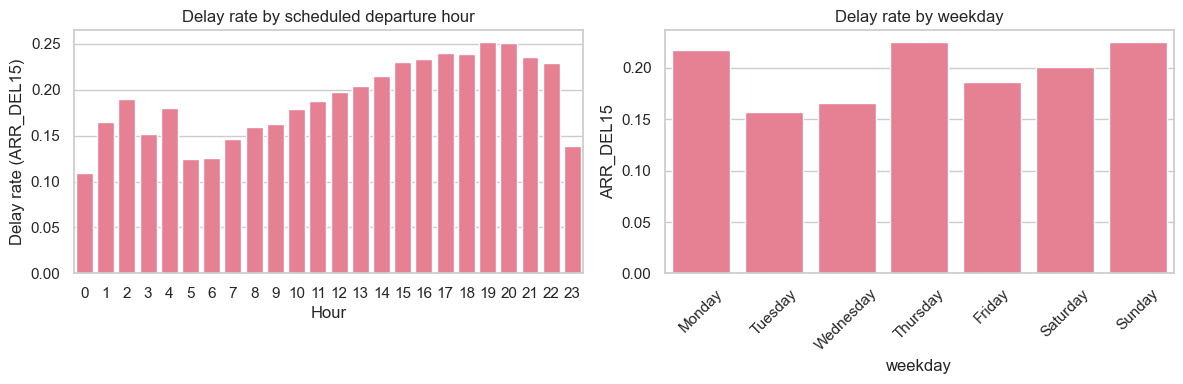

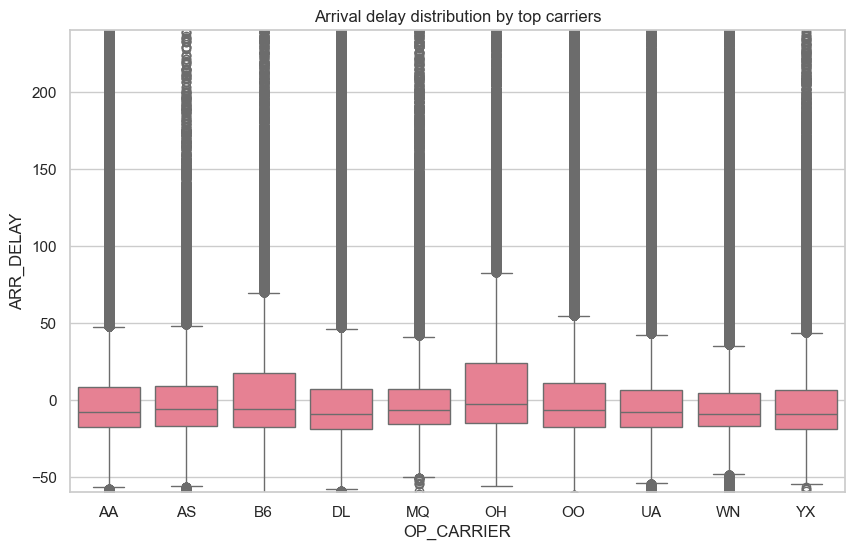

In [12]:

# Basic dataset overview
print('Rows, columns:', df.shape)
print('Date range:', df['FL_DATE'].min(), '->', df['FL_DATE'].max())
print('\nTarget (ARR_DEL15) distribution:')
print(df['ARR_DEL15'].value_counts(dropna=False, normalize=True))

# Missingness summary (top columns)
missing = df.isnull().mean().sort_values(ascending=False)
print('\nTop columns by fraction missing:')
print(missing[missing>0].head(20))

# Basic counts
print('\nUnique carriers:', df['OP_CARRIER'].nunique())
print('Unique origins:', df['ORIGIN'].nunique())
print('Unique destinations:', df['DEST'].nunique())

# Delay threshold summary
for thr in [15, 30, 60]:
    col = f'ARR_DEL_gt_{thr}'
    df[col] = (df['ARR_DELAY'] > thr).astype(int)
    print(f"% flights with arrival delay > {thr} min: {df[col].mean():.3f}")

# Cancellations / diversions
if 'CANCELLED' in df.columns:
    print('\nCancelled fraction:', df['CANCELLED'].mean())
if 'DIVERTED' in df.columns:
    print('Diverted fraction:', df['DIVERTED'].mean())

# Top carriers / origins / routes by count and delay rate
print('\nTop 10 carriers by flights and delay rate:')
carrier_stats = df.groupby('OP_CARRIER').agg(n=('ARR_DEL15','count'), delay_rate=('ARR_DEL15','mean')).sort_values('n', ascending=False).head(10)
print(carrier_stats)

print('\nTop 10 origin airports by volume and delay rate:')
origin_stats = df.groupby('ORIGIN').agg(n=('ARR_DEL15','count'), delay_rate=('ARR_DEL15','mean')).sort_values('n', ascending=False).head(10)
print(origin_stats)

# Top routes
if 'ROUTE' not in df.columns:
    df['ROUTE'] = df['ORIGIN'].astype(str) + '-' + df['DEST'].astype(str)
route_stats = df.groupby('ROUTE').agg(n=('ARR_DEL15','count'), delay_rate=('ARR_DEL15','mean')).sort_values('n', ascending=False).head(10)
print('\nTop 10 routes by flights:')
print(route_stats)

# Temporal summaries: hour and weekday
if 'DEP_HOUR' not in df.columns and 'CRS_DEP_TIME' in df.columns:
    df['DEP_HOUR'] = (df['CRS_DEP_TIME'] // 100).astype(int)

if 'FL_DATE' in df.columns:
    df['FL_DATE'] = pd.to_datetime(df['FL_DATE'])
    df['weekday'] = df['FL_DATE'].dt.day_name()

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.barplot(x='DEP_HOUR', y='ARR_DEL15', data=df, ci=None)
plt.title('Delay rate by scheduled departure hour')
plt.xlabel('Hour')
plt.ylabel('Delay rate (ARR_DEL15)')

plt.subplot(1,2,2)
sns.barplot(x='weekday', y='ARR_DEL15', data=df, order=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'], ci=None)
plt.title('Delay rate by weekday')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Simple boxplot of arrival delay by top carriers
top_carriers = carrier_stats.index.tolist()
plt.figure(figsize=(10,6))
sns.boxplot(data=df[df['OP_CARRIER'].isin(top_carriers)], x='OP_CARRIER', y='ARR_DELAY')
plt.title('Arrival delay distribution by top carriers')
plt.ylim(-60, 240)
plt.show()

### Delay Distribution Comparison

Comparing departure delays vs. arrival delays to understand delay patterns:

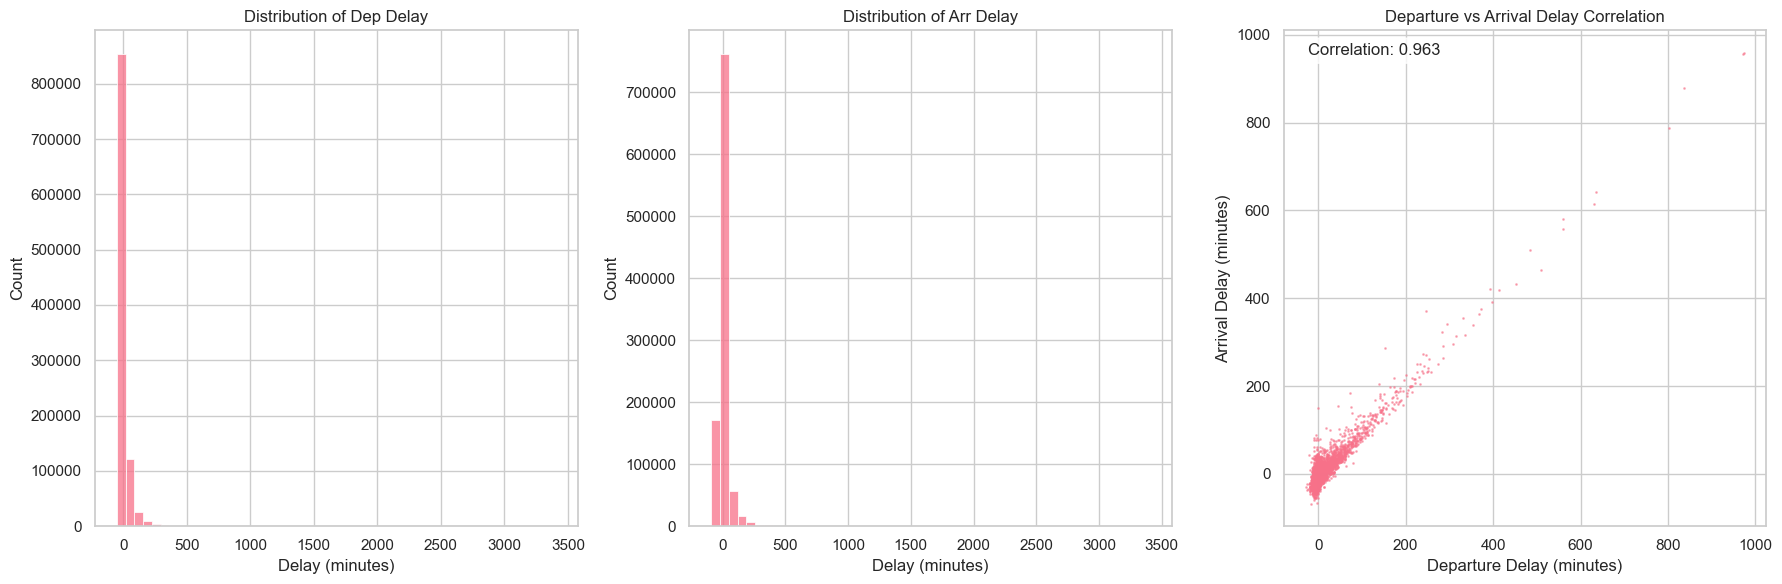

In [13]:
# Plot departure and arrival delays side by side
fig, axes = plot_delay_distribution(df, ['DEP_DELAY', 'ARR_DELAY'])
plt.show()

Strong correlation between Departure Delay and Arrival Delay. In initial_exploration I have learned that dep_delay is the strongest predictor for arrival delay.

### 2. Carrier Analysis

Next, let's analyze how different carriers perform in terms of delays:

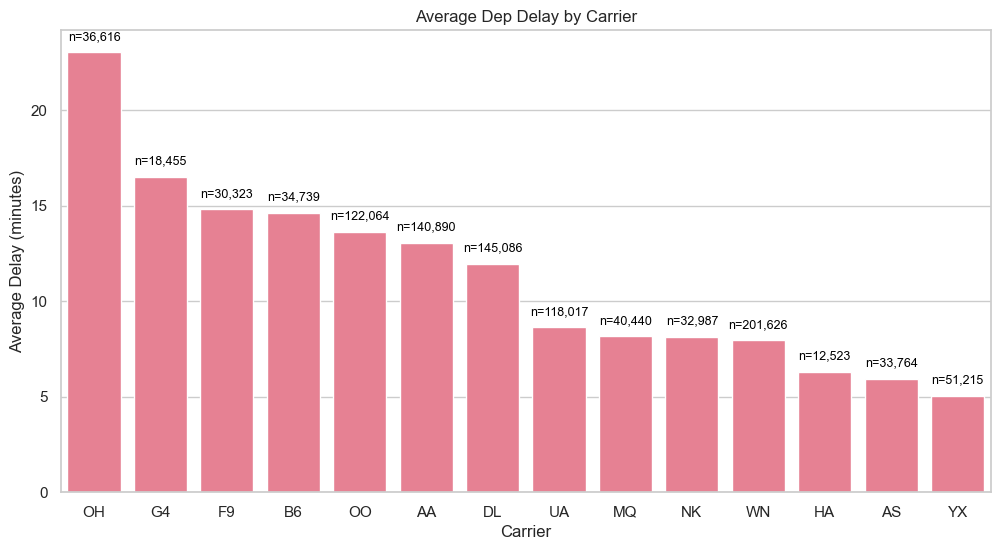

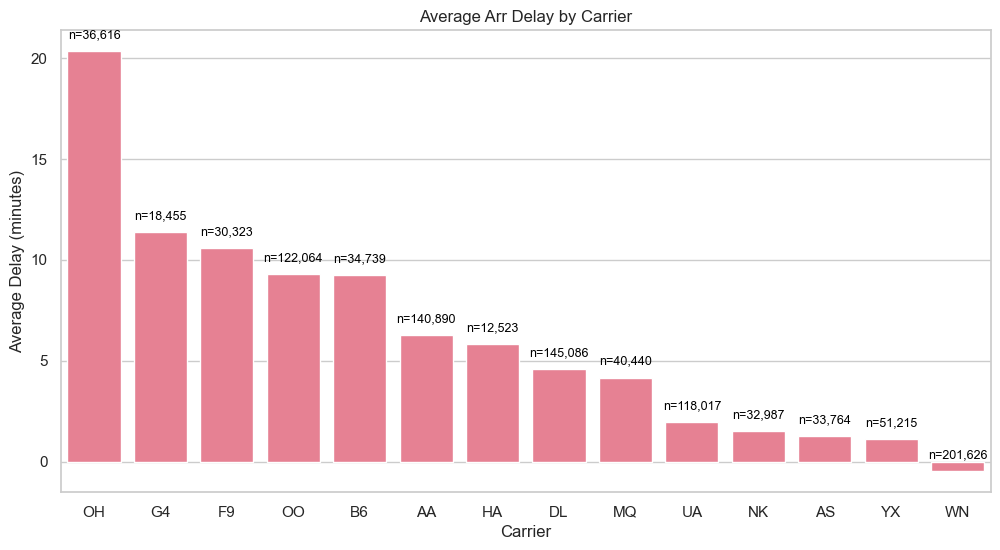

In [14]:
# Analyze departure delays by carrier
plot_delays_by_carrier(df, 'DEP_DELAY')
plt.show()

# Analyze arrival delays by carrier
plot_delays_by_carrier(df, 'ARR_DELAY')
plt.show()

### 3. Time of Day Analysis

Let's examine how delays vary throughout the day:

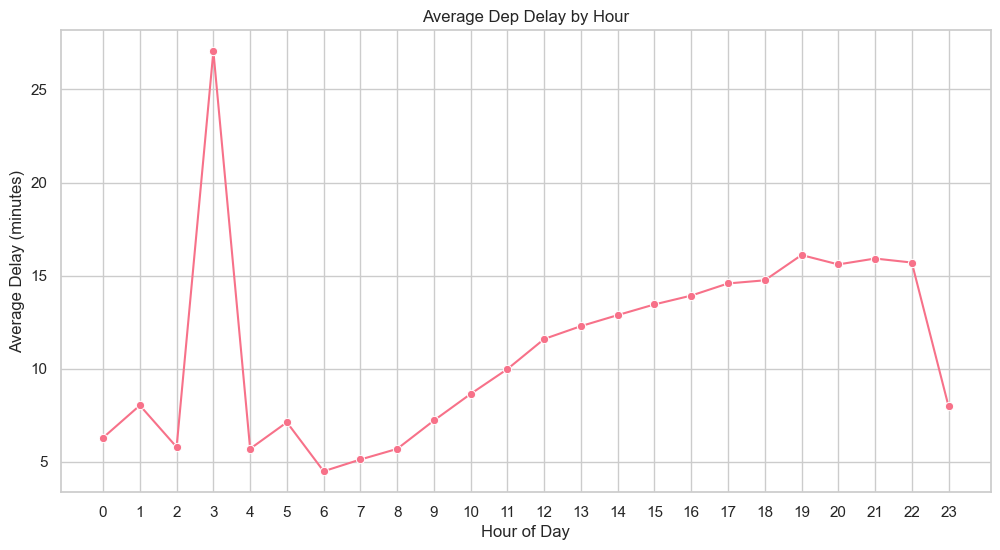

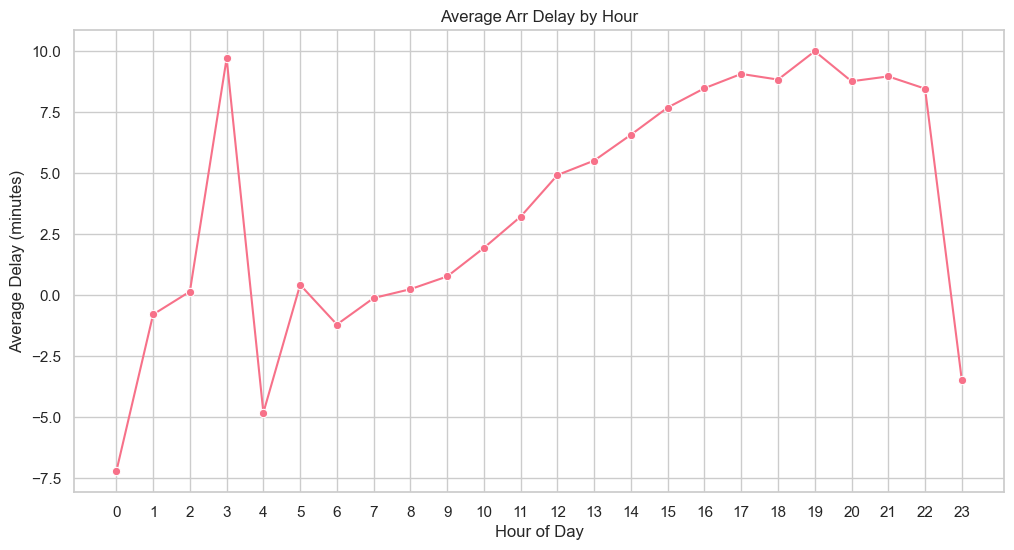

In [15]:
# Plot delays by hour
plot_delays_by_hour(df, 'DEP_DELAY')
plt.show()

# Compare with arrival delays
plot_delays_by_hour(df, 'ARR_DELAY')
plt.show()

Average Departure and Arrival Delay by Hour of Day

- Daytime pattern (6 AM - 11 PM): Delays steadily accumulate from ~0 minutes in early morning to ~10 minutes by evening, demonstrating how operational issues compound throughout the day
- Overnight volatility (12 AM - 5 AM): Potentially red eye flights and additional erratic pattern with extreme spikes reflects significantly fewer flights and higher measurement error, making these averages less reliable than daytime data

### 4. Feature Correlations

Let's analyze how different features are correlated with delays and each other. This helps us understand:
- Which features are most predictive of delays
- Which features are highly correlated (potential multicollinearity)
- Relationships between operational and weather factors

Selected 14 numeric features for correlation analysis:
['ARR_DEL_gt_15', 'ARR_DEL_gt_30', 'ARR_DELAY', 'ARR_DEL_gt_60', 'DEP_DELAY', 'DEP_HOUR', 'WEATHER_RISK_ORIGIN', 'ORIGIN_WSPD', 'ARR_HOUR', 'ORIGIN_TEMP', 'WEATHER_RISK_DEST', 'DEST_WSPD', 'ORIGIN_LON', 'ORIGIN_PRCP']


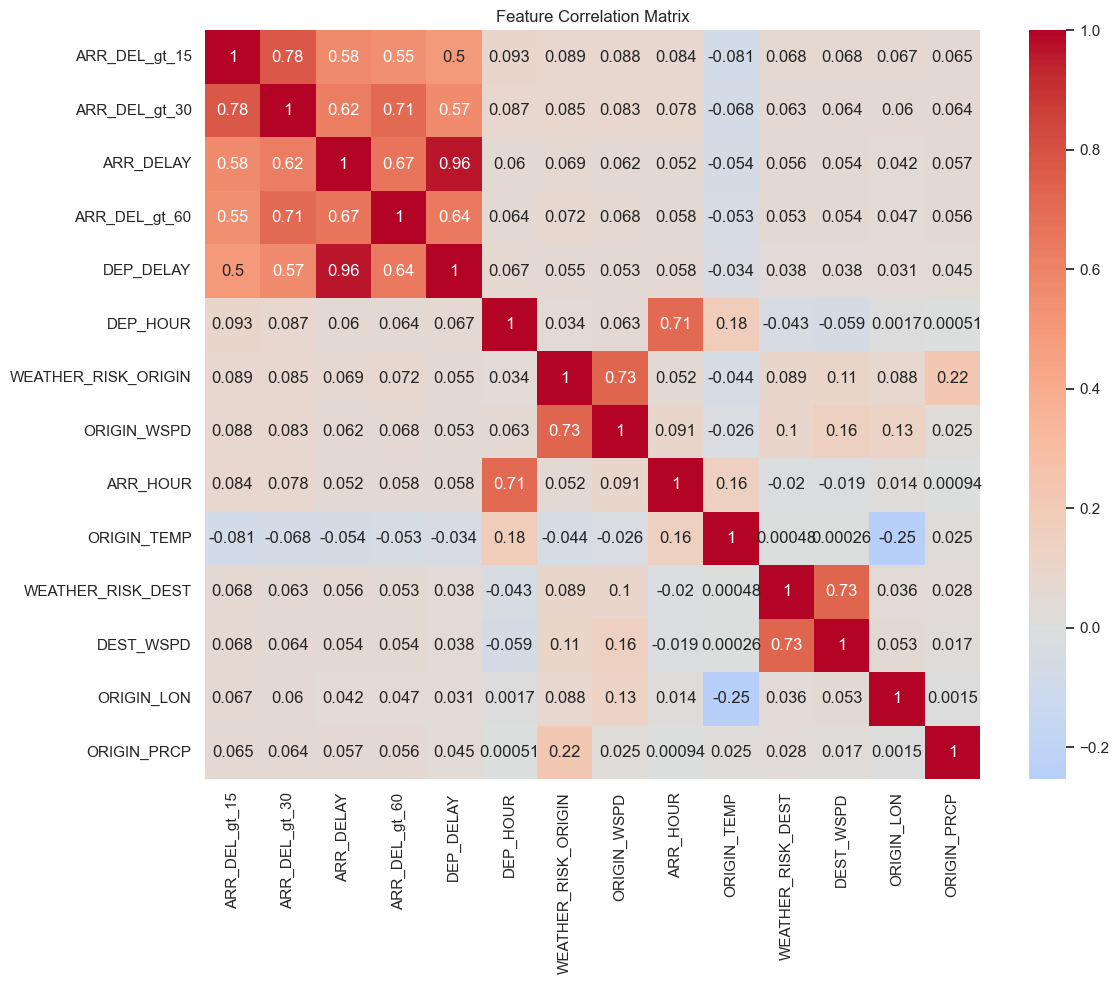


📊 Top Correlations with Delay Target (ARR_DEL15):
 1. ARR_DEL_gt_15        0.9798
 2. ARR_DEL_gt_30        0.7630
 3. DEP_DEL15            0.7154
 4. ARR_DELAY            0.5716
 5. ARR_DEL_gt_60        0.5430
 6. DEP_DELAY            0.4897
 7. CRS_DEP_TIME         0.0935
 8. DEP_HOUR             0.0933
 9. WEATHER_RISK_ORIGIN  0.0890
10. ORIGIN_WSPD          0.0884


In [18]:
# Select relevant numeric columns for correlation analysis
# Get all numeric columns and filter out ID columns and the target
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# Remove ID columns, target variable, and direct leakage columns
exclude_cols = [
    'ARR_DEL15',  # Target variable
    'DEP_DEL15',  # Direct leakage
    'OP_CARRIER_FL_NUM',  # ID column
    'FL_DATE',  # Date (if numeric)
    'CRS_DEP_TIME',  # Time (if numeric)
    'CRS_ARR_TIME',  # Time (if numeric)
    'CRS_ELAPSED_TIME'  # Derived from above
]

# Filter to relevant numeric columns
correlation_cols = [col for col in numeric_cols if col not in exclude_cols]

# Limit to most relevant columns for readability (top correlations with target)
if len(correlation_cols) > 15:
    # Calculate correlations with target and select top features
    target_corrs = df[correlation_cols + ['ARR_DEL15']].corr()['ARR_DEL15'].abs().sort_values(ascending=False)
    correlation_cols = target_corrs.head(15).index.tolist()
    if 'ARR_DEL15' in correlation_cols:
        correlation_cols.remove('ARR_DEL15')

print(f"Selected {len(correlation_cols)} numeric features for correlation analysis:")
print(correlation_cols)

# Create correlation matrix
plot_correlation_matrix(df, correlation_cols)
plt.show()

# Show top correlations with target variable
print("\n📊 Top Correlations with Delay Target (ARR_DEL15):")
print("=" * 50)
all_numeric = df.select_dtypes(include=[np.number]).columns.tolist()
target_correlations = df[all_numeric].corrwith(df['ARR_DEL15']).abs().sort_values(ascending=False)
target_correlations = target_correlations.drop('ARR_DEL15', errors='ignore')  # Remove self-correlation

for i, (feature, corr) in enumerate(target_correlations.head(10).items(), 1):
    print(f"{i:2d}. {feature:<20} {corr:.4f}")


Interpretation:
- Values closer to 1.0 indicate stronger linear relationships with delays
- Weather, time, and operational factors show varying predictive power
- Multiple correlated features may indicate redundancy or complementary information

### 5. Weather Impact Analysis

Finally, let's examine how weather conditions affect flight delays:

### Weather Impact Analysis

Analyzing how weather conditions at origin and destination affect departure delays:

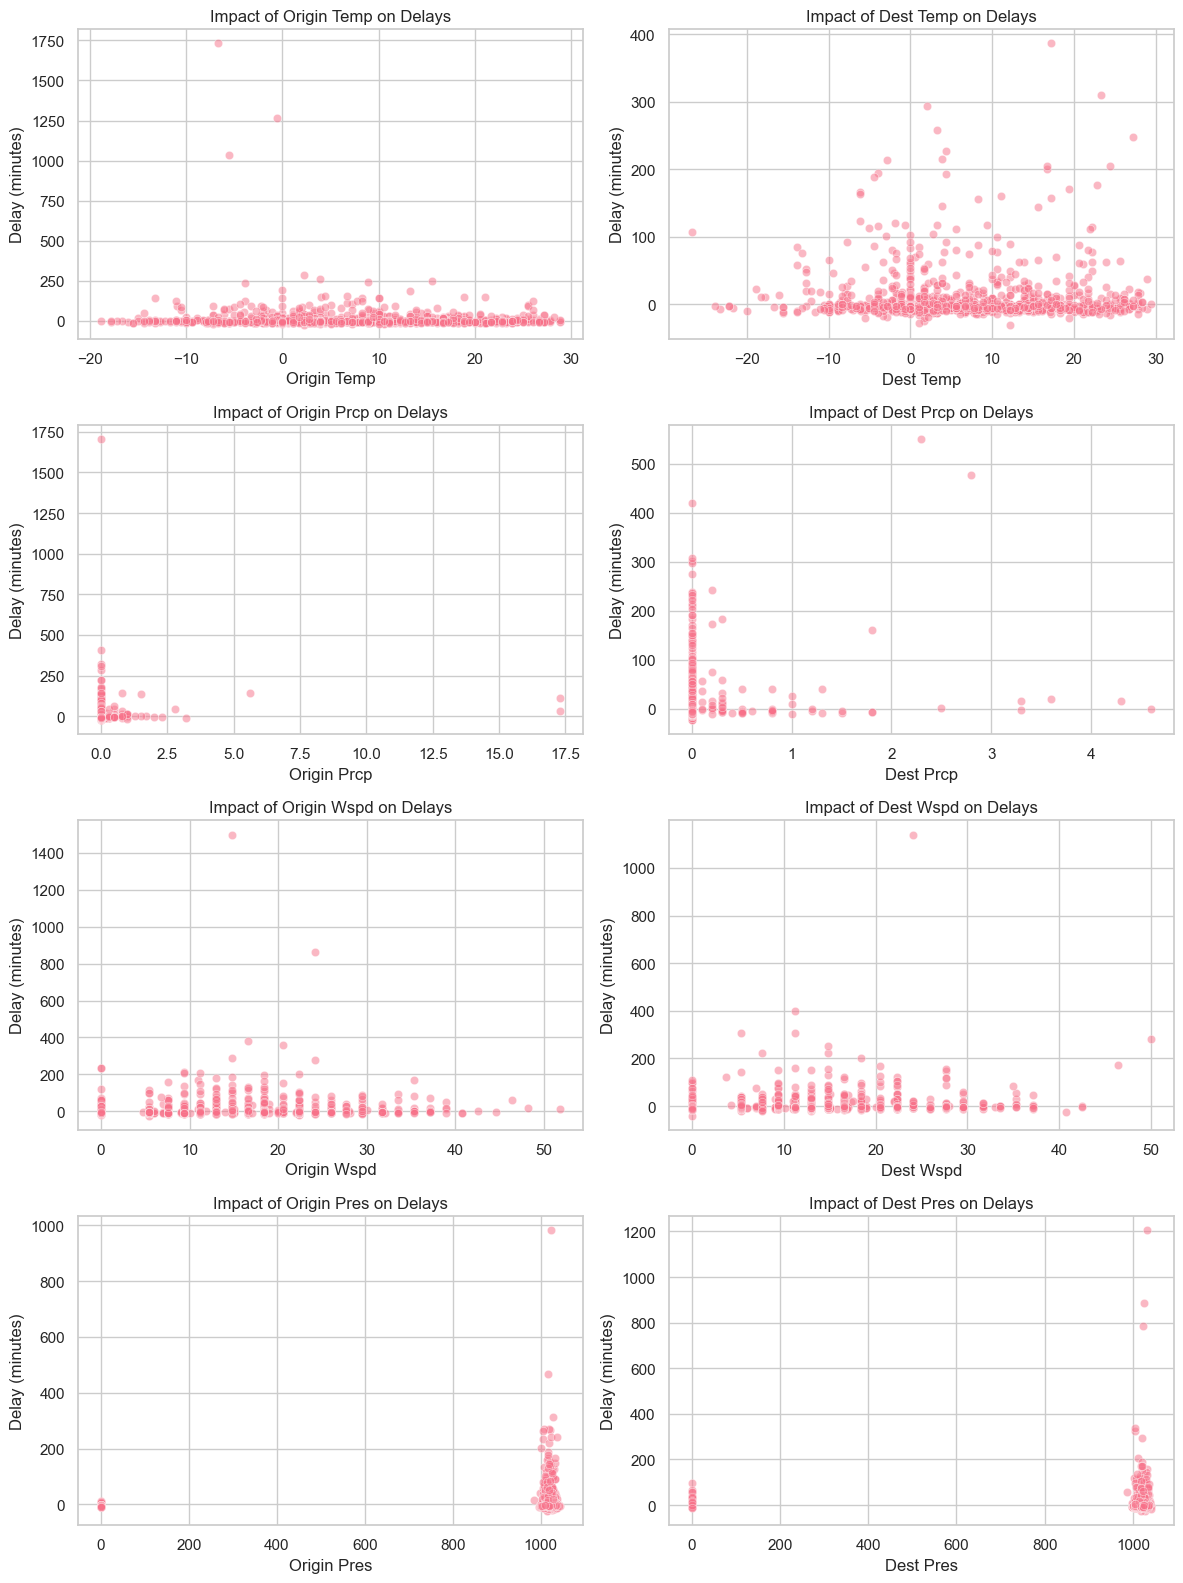

In [20]:
# Analyze weather impacts
weather_features = ['ORIGIN_TEMP', 'DEST_TEMP','ORIGIN_PRCP', 
                    'DEST_PRCP', 'ORIGIN_WSPD', 'DEST_WSPD','ORIGIN_PRES','DEST_PRES'
                    ]
plot_weather_impact(df, weather_features, 'DEP_DELAY')
plt.show()

Weather doesnt seem to be highly predictive. My interpretation is that really bad weather causes flights to be cancelled and not delayed. Therefore only a moderate impact is seen.

### Additional EDA from `initial_exploration.ipynb`

The initial exploration notebook contains a number of valuable exploratory analyses. Below we reproduce and extend the most useful ones:

- Busiest airports by volume
- Delay rate by origin (airport) and carrier
- Top routes by delay rate (filtered by min flights)
- Inbound-flight (tail) delay propagation effect
- Daily delay rate trend and special event 

These are implemented in `src/visualization/plots.py` and are executed in the cell that follows.

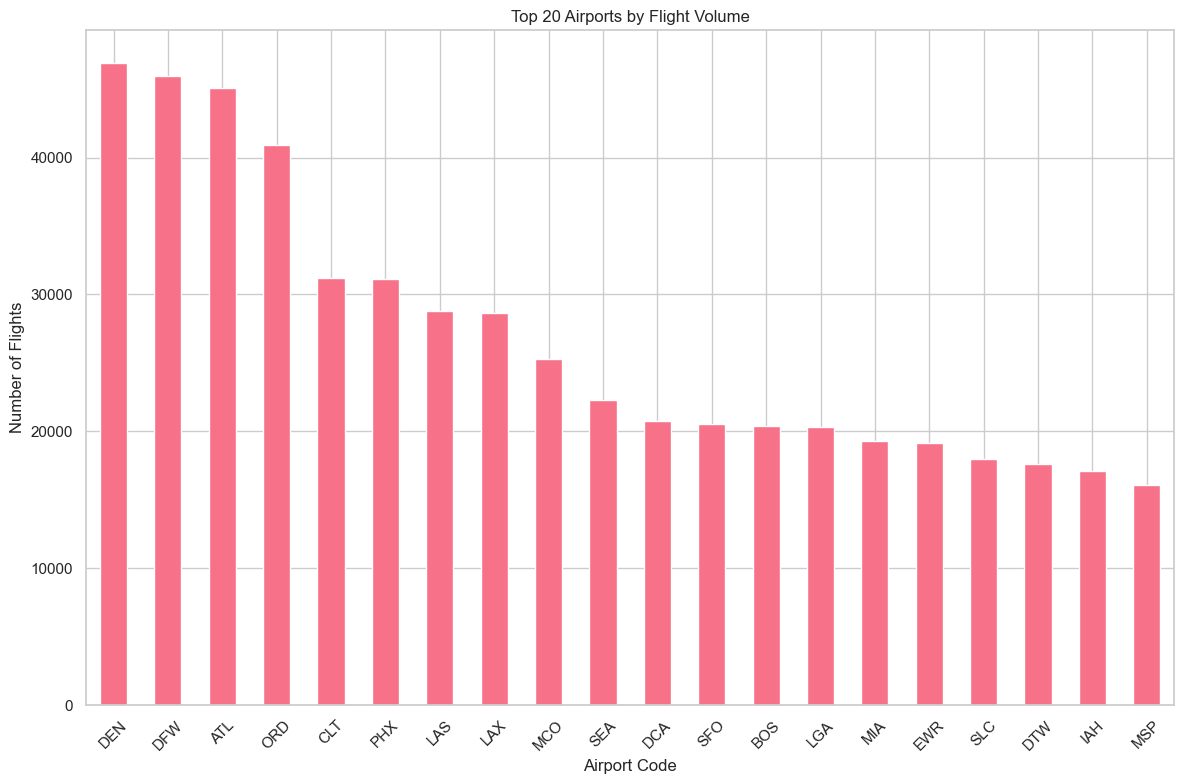

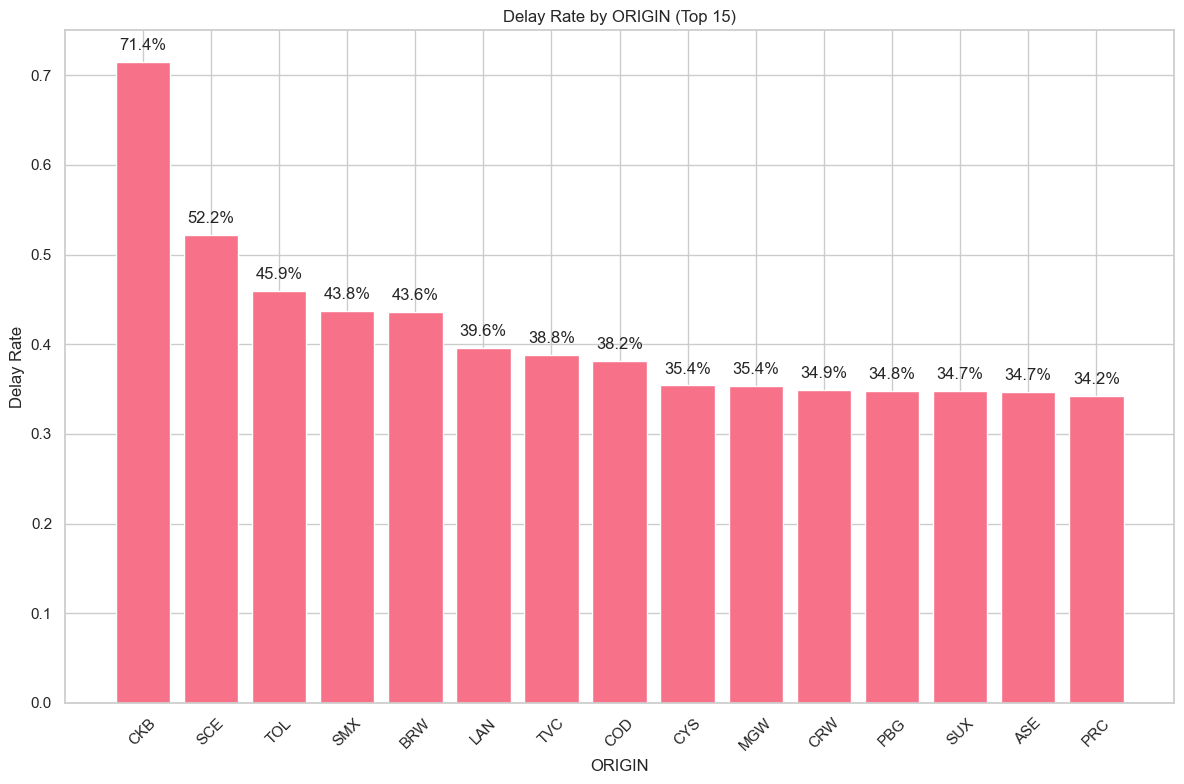

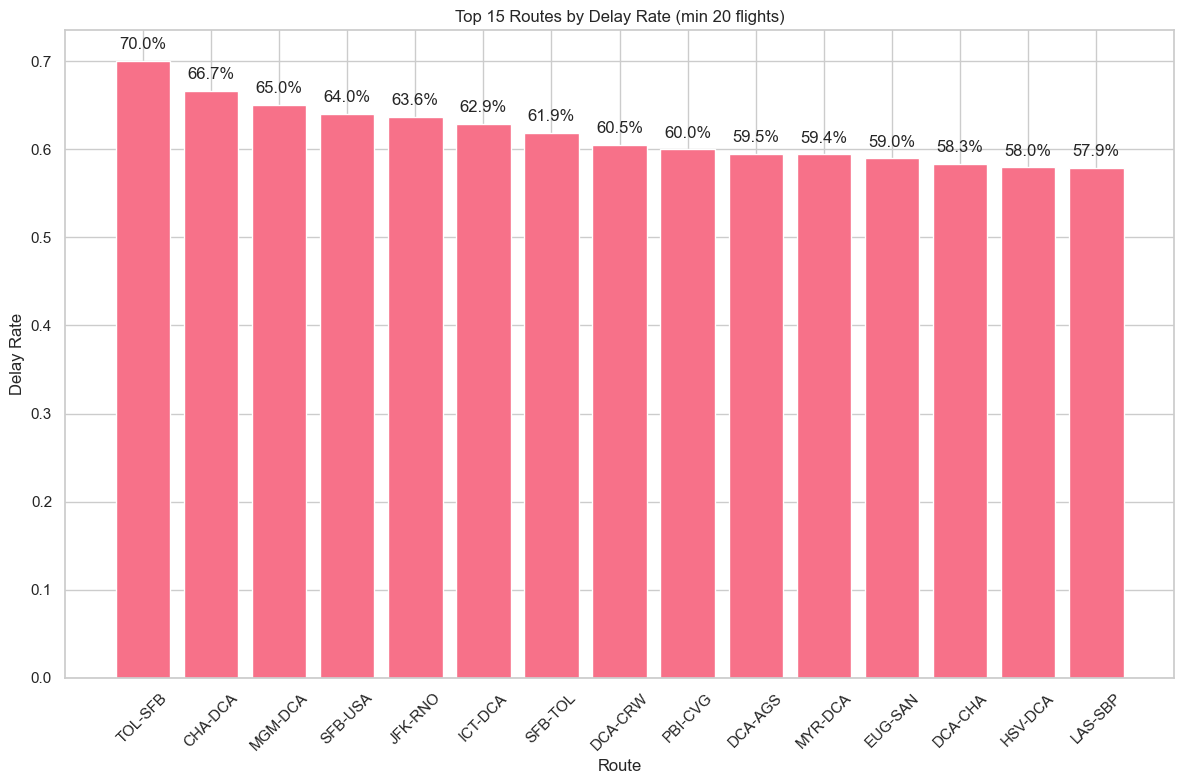

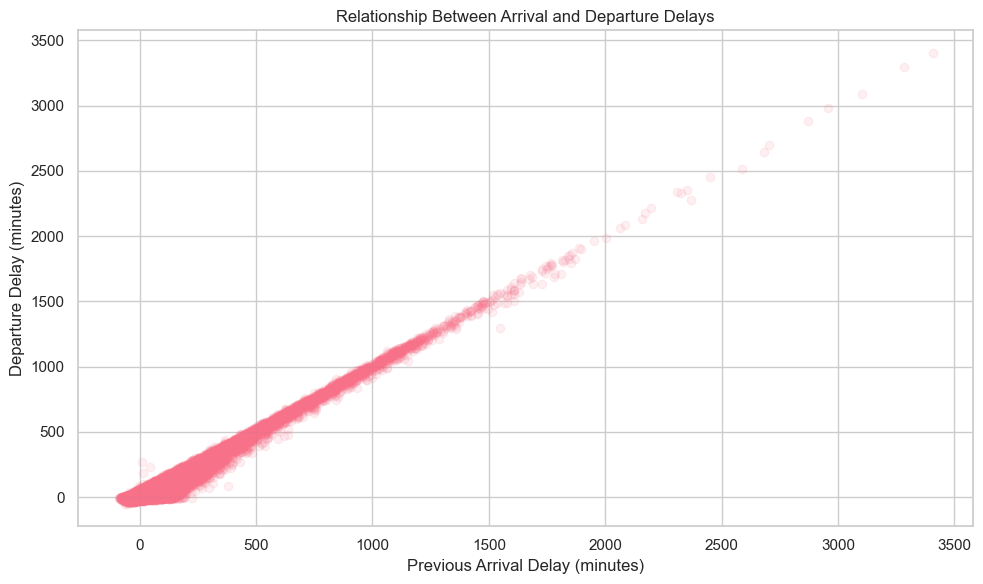

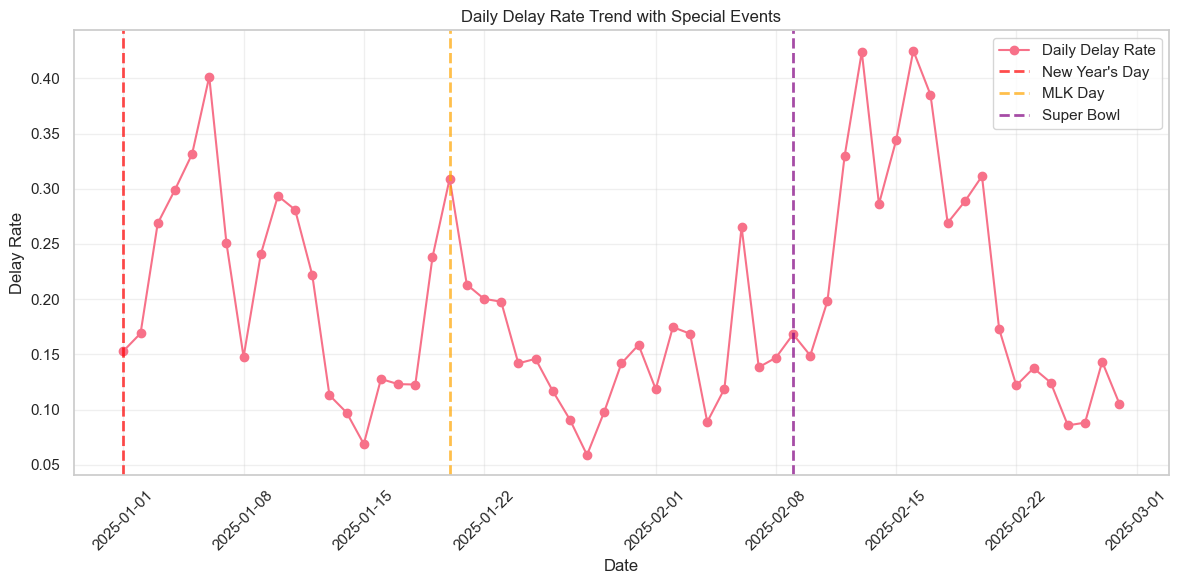

In [23]:
# Import additional plotting helpers
from src.visualization import (
    plot_missingness,
    plot_top_airports_by_volume,
    plot_top_routes_delay,
    plot_delay_rate_by_group,
    plot_inbound_delay_effect,
    plot_daily_delay_trend,
)

# Ensure plotting style
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})

try:
    fig, ax = plot_top_airports_by_volume(df, n=20)
    plt.show()
except Exception as e:
    print('Top airports plot failed:', e)

# 3) Delay rate by origin (top 15)
try:
    fig, ax = plot_delay_rate_by_group(df, 'ORIGIN', top_n=15)
    plt.show()
except Exception as e:
    print('Delay rate by origin failed:', e)

# 4) Top routes by delay rate (filter small routes)
try:
    fig, ax = plot_top_routes_delay(df, n=15, min_flights=20)
    plt.show()
except Exception as e:
    print('Top routes plot failed:', e)

# 5) Inbound (tail) delay propagation effect
try:
    fig, ax = plot_inbound_delay_effect(df)
    plt.show()
except Exception as e:
    print('Inbound delay effect plot failed:', e)

# 6) Daily delay rate trend
try:
    fig, ax = plot_daily_delay_trend(df)
    plt.show()
except Exception as e:
    print('Daily delay trend plot failed:', e)


This clearly shows that the flight delays are impacted by Special Events or Holidays

## Prepare Features for Modeling

Now we'll prepare the features for modeling, excluding any data leakage columns:

In [24]:
# Apply additional feature engineering using our feature engineering module
print("Applying feature engineering...")
df_engineered = engineer_all_features(df)


Applying feature engineering...
🔧 Starting feature engineering...
✅ Time features created
✅ Route features created
✅ Carrier features created
✅ Aircraft features created
✅ Weather features created
✅ Advanced temporal features created
🔧 Feature engineering complete! Dataset shape: (1018745, 105)


# Feature Engineering Documentation

## Summary Statistics
- **Total Engineered Features**: ~70+ features
- **Feature Categories**: 6 (Time, Route, Carrier, Aircraft, Weather, Advanced Temporal)
- **Raw Input Features**: ~18 columns → **Final Feature Set**: ~70+ features

---

## Feature Engineering Table

| Feature Name | Formula/Logic | Category | Data Type | Rationale/Business Logic |
|--------------|--------------|----------|-----------|--------------------------|
| **TIME-BASED FEATURES** |
| MONTH | `FL_DATE.dt.month` | Time | int | Seasonal patterns (winter weather, summer travel) |
| DAY_OF_MONTH | `FL_DATE.dt.day` | Time | int | Monthly patterns (paydays, month-end travel) |
| WEEKDAY | `FL_DATE.dt.day_name()` | Time | str | Day-of-week effects (weekend vs weekday) |
| IS_WEEKEND | `FL_DATE.dt.weekday in [5,6]` | Time | binary | Weekends have different delay patterns |
| DEP_HOUR | `CRS_DEP_TIME // 100` | Time | int | Hour of day affects congestion |
| ARR_HOUR | `CRS_ARR_TIME // 100` | Time | int | Arrival hour for destination congestion |
| DEP_PERIOD | `categorize_time_period(DEP_HOUR)` | Time | categorical | Morning/Afternoon/Evening/Night patterns |
| ARR_PERIOD | `categorize_time_period(ARR_HOUR)` | Time | categorical | Arrival time period for scheduling |
| TIME_BUCKET | `DEP_HOUR // 6` | Time | int | 6-hour windows (0-6, 6-12, 12-18, 18-24) |
| TIME_BUCKET_LABEL | Map TIME_BUCKET to string | Time | str | Human-readable time buckets |
| IS_RUSH_HOUR | `DEP_HOUR in [7-9, 17-19]` | Time | binary | Peak traffic hours → more delays |
| IS_HOLIDAY_SEASON | `MONTH in [11,12]` | Time | binary | Holiday travel → higher congestion (dataset is limited to 2 months) |
| IS_SUMMER | `MONTH in [6,7,8]` | Time | binary | Summer vacation travel patterns (dataset is limited to 2 months) |
| FL_DATETIME | `FL_DATE + DEP_HOUR + DEP_MINUTE` | Time | datetime | Complete timestamp for sorting/windowing |
| **ROUTE-BASED FEATURES** |
| ROUTE | `ORIGIN + '-' + DEST` | Route | str | Unique route identifier |
| REVERSE_ROUTE | `DEST + '-' + ORIGIN` | Route | str | Bidirectional route analysis |
| DISTANCE_CATEGORY | `pd.cut(DISTANCE, [0,500,1000,2000,inf])` | Route | categorical | SHORT/MEDIUM/LONG/VERY_LONG flights |
| ESTIMATED_FLIGHT_TIME | `DISTANCE / 500` | Route | float | Rough flight duration in hours |
| ORIGIN_IS_HUB | `ORIGIN in major_hubs` | Route | binary | Hub airports have different delay patterns |
| DEST_IS_HUB | `DEST in major_hubs` | Route | binary | Destination hub affects congestion |
| HUB_TO_HUB | `ORIGIN_IS_HUB & DEST_IS_HUB` | Route | binary | Hub-to-hub routes are busier |
| SAME_STATE | `ORIGIN_STATE == DEST_STATE` | Route | binary | Intrastate flights are shorter |
| ORIGIN_WEST_COAST | `ORIGIN_STATE in [CA,OR,WA,NV,AZ]` | Route | binary | West coast weather/congestion patterns |
| ORIGIN_EAST_COAST | `ORIGIN_STATE in [NY,NJ,MA,...]` | Route | binary | East coast density affects delays |
| DEST_WEST_COAST | `DEST_STATE in west_coast` | Route | binary | Destination coast patterns |
| DEST_EAST_COAST | `DEST_STATE in east_coast` | Route | binary | Destination coast patterns |
| COAST_TO_COAST | `(WEST→EAST) or (EAST→WEST)` | Route | binary | Transcontinental flights have unique patterns |
| **CARRIER-BASED FEATURES** |
| IS_MAJOR_CARRIER | `CARRIER in [AA,DL,UA,WN]` | Carrier | binary | Major carriers have different operations |
| IS_LOW_COST_CARRIER | `CARRIER in [WN,B6,NK,F9,G4]` | Carrier | binary | Budget airlines have tighter schedules |
| IS_REGIONAL_CARRIER | `CARRIER in [OO,YX,MQ,OH,...]` | Carrier | binary | Regional carriers use smaller airports |
| CARRIER_DELAY_RATE | `groupby(CARRIER).ARR_DEL15.mean()` | Carrier | float | Historical carrier performance |
| CARRIER_FLIGHT_COUNT | `groupby(CARRIER).count()` | Carrier | int | Carrier size/market presence |
| CARRIER_AVG_DISTANCE | `groupby(CARRIER).DISTANCE.mean()` | Carrier | float | Typical carrier route length |
| CARRIER_SIZE | `pd.cut(CARRIER_FLIGHT_COUNT)` | Carrier | categorical | SMALL/MEDIUM/LARGE/MAJOR classification |
| **AIRCRAFT-BASED FEATURES** |
| TAIL_NUM_CLEAN | `TAIL_NUM.strip().upper()` | Aircraft | str | Cleaned aircraft identifier |
| TAIL_NUM_PREFIX | `TAIL_NUM[:2]` | Aircraft | str | Registration pattern (not used in model) |
| TAIL_NUM_NUMERIC | `extract(\d+)` | Aircraft | float | Numeric portion of tail number |
| AIRCRAFT_DELAY_RATE | `groupby(TAIL_NUM).ARR_DEL15.mean()` | Aircraft | float | **MOST IMPORTANT**: Individual aircraft delay history |
| AIRCRAFT_FLIGHT_COUNT | `groupby(TAIL_NUM).count()` | Aircraft | int | Aircraft utilization level |
| AIRCRAFT_AVG_DISTANCE | `groupby(TAIL_NUM).DISTANCE.mean()` | Aircraft | float | Typical routes for this aircraft |
| AIRCRAFT_UTILIZATION | `pd.cut(AIRCRAFT_FLIGHT_COUNT)` | Aircraft | categorical | LOW/MEDIUM/HIGH/VERY_HIGH usage |
| MFR_YEAR | From FAA registry data | Aircraft | int | Manufacturing year |
| AIRCRAFT_AGE | `current_year - MFR_YEAR` | Aircraft | int | Age affects maintenance delays |
| AIRCRAFT_AGE_CATEGORY | `pd.cut(AIRCRAFT_AGE)` | Aircraft | categorical | NEW/MODERN/MATURE/OLD classification |
| **WEATHER-BASED FEATURES** |
| TEMP_DIFF | `DEST_TEMP - ORIGIN_TEMP` | Weather | float | Temperature change affects operations |
| TEMP_DIFF_ABS | `abs(TEMP_DIFF)` | Weather | float | Magnitude of temperature change |
| PRESSURE_DIFF | `DEST_PRES - ORIGIN_PRES` | Weather | float | Pressure systems affect weather |
| PRESSURE_DIFF_ABS | `abs(PRESSURE_DIFF)` | Weather | float | Weather system transition |
| WEATHER_RISK_COMBINED | `WEATHER_RISK_ORIGIN + WEATHER_RISK_DEST` | Weather | float | Total weather risk score |
| EXTREME_COLD_ORIGIN | `ORIGIN_TEMP < -10` | Weather | binary | De-icing procedures required |
| EXTREME_HEAT_ORIGIN | `ORIGIN_TEMP > 35` | Weather | binary | High temperature affects performance |
| EXTREME_COLD_DEST | `DEST_TEMP < -10` | Weather | binary | Destination cold weather |
| EXTREME_HEAT_DEST | `DEST_TEMP > 35` | Weather | binary | Destination heat |
| HIGH_WIND_ORIGIN | `ORIGIN_WSPD > 25` | Weather | binary | Crosswinds affect takeoff/landing |
| HIGH_WIND_DEST | `DEST_WSPD > 25` | Weather | binary | Destination wind conditions |
| HEAVY_RAIN_ORIGIN | `ORIGIN_PRCP > 2.0` | Weather | binary | Heavy precipitation → delays |
| HEAVY_RAIN_DEST | `DEST_PRCP > 2.0` | Weather | binary | Destination precipitation |
| WEATHER_SEVERITY_ORIGIN | Composite score (0-10) | Weather | int | Combined weather risk at origin |
| WEATHER_SEVERITY_DEST | Composite score (0-10) | Weather | int | Combined weather risk at destination |
| WEATHER_SEVERITY_MAX | `max(ORIGIN, DEST severity)` | Weather | int | Worst weather between endpoints |
| **ADVANCED TEMPORAL FEATURES** |
| AIRPORT_HOUR_DELAY_RATE | `groupby(ORIGIN, DEP_HOUR).ARR_DEL15.mean()` | Temporal | float | Airport congestion by hour |
| AIRPORT_HOUR_FLIGHT_COUNT | `groupby(ORIGIN, DEP_HOUR).count()` | Temporal | int | Traffic volume at that hour |
| AIRPORT_WEEKDAY_DELAY_RATE | `groupby(ORIGIN, WEEKDAY).ARR_DEL15.mean()` | Temporal | float | Day-of-week airport patterns |
| AIRPORT_WEEKDAY_FLIGHT_COUNT | `groupby(ORIGIN, WEEKDAY).count()` | Temporal | int | Weekly traffic patterns |
| ROUTE_DELAY_RATE | `groupby(ROUTE).ARR_DEL15.mean()` | Temporal | float | Historical route performance |
| ROUTE_FLIGHT_COUNT | `groupby(ROUTE).count()` | Temporal | int | Route frequency/popularity |
| ROUTE_AVG_DISTANCE | `groupby(ROUTE).DISTANCE.mean()` | Temporal | float | Typical route distance |

---

## Features Excluded from Modeling (Leakage Prevention)

| Feature | Reason for Exclusion |
|---------|---------------------|
| DEP_DELAY | **Direct leakage**: Not known before flight departs |
| ARR_DELAY | **Direct leakage**: Target-related information |
| DEP_DEL15 | **Leakage**: Departure delay predicts arrival delay too well |
| CANCELLED | **Post-flight**: Only known after the fact |
| DIVERTED | **Post-flight**: Only known after the fact |
| FL_DATE | **Redundant**: Engineered into time features |
| TAIL_NUM | **High cardinality ID**: Engineered into aggregate features |
| OP_CARRIER_FL_NUM | **ID column**: No predictive value |
| WEEKDAY (string) | **Redundant**: Kept numeric version (DAY_OF_WEEK) |




In [25]:
print(df_engineered.columns.tolist())

['DAY_OF_WEEK', 'FL_DATE', 'OP_CARRIER', 'TAIL_NUM', 'OP_CARRIER_FL_NUM', 'ORIGIN', 'ORIGIN_STATE_ABR', 'DEST', 'DEST_STATE_ABR', 'CRS_DEP_TIME', 'DEP_DELAY', 'DEP_DEL15', 'CRS_ARR_TIME', 'ARR_DELAY', 'ARR_DEL15', 'CANCELLED', 'DIVERTED', 'DISTANCE', 'ORIGIN_LAT', 'ORIGIN_LON', 'ORIGIN_TYPE', 'DEST_LAT', 'DEST_LON', 'DEST_TYPE', 'DEP_HOUR', 'ARR_HOUR', 'ORIGIN_TEMP', 'ORIGIN_WSPD', 'ORIGIN_PRCP', 'ORIGIN_PRES', 'DEST_TEMP', 'DEST_WSPD', 'DEST_PRCP', 'DEST_PRES', 'WEATHER_MISSING', 'WEATHER_RISK_ORIGIN', 'WEATHER_RISK_DEST', 'ARR_DEL_gt_15', 'ARR_DEL_gt_30', 'ARR_DEL_gt_60', 'ROUTE', 'weekday', 'MONTH', 'DAY_OF_MONTH', 'WEEKDAY', 'IS_WEEKEND', 'DEP_PERIOD', 'ARR_PERIOD', 'TIME_BUCKET', 'TIME_BUCKET_LABEL', 'IS_RUSH_HOUR', 'IS_HOLIDAY_SEASON', 'IS_SUMMER', 'REVERSE_ROUTE', 'DISTANCE_CATEGORY', 'ESTIMATED_FLIGHT_TIME', 'ORIGIN_IS_HUB', 'DEST_IS_HUB', 'HUB_TO_HUB', 'SAME_STATE', 'ORIGIN_WEST_COAST', 'ORIGIN_EAST_COAST', 'DEST_WEST_COAST', 'DEST_EAST_COAST', 'COAST_TO_COAST', 'IS_MAJOR_CARR

### Feature Correlation Analysis

Examining correlations among engineered features to identify multicollinearity:

(<Figure size 1400x1200 with 2 Axes>,
 <Axes: title={'center': 'Feature Correlation Matrix\n(Ordered by correlation strength with ARR_DEL15)'}>)

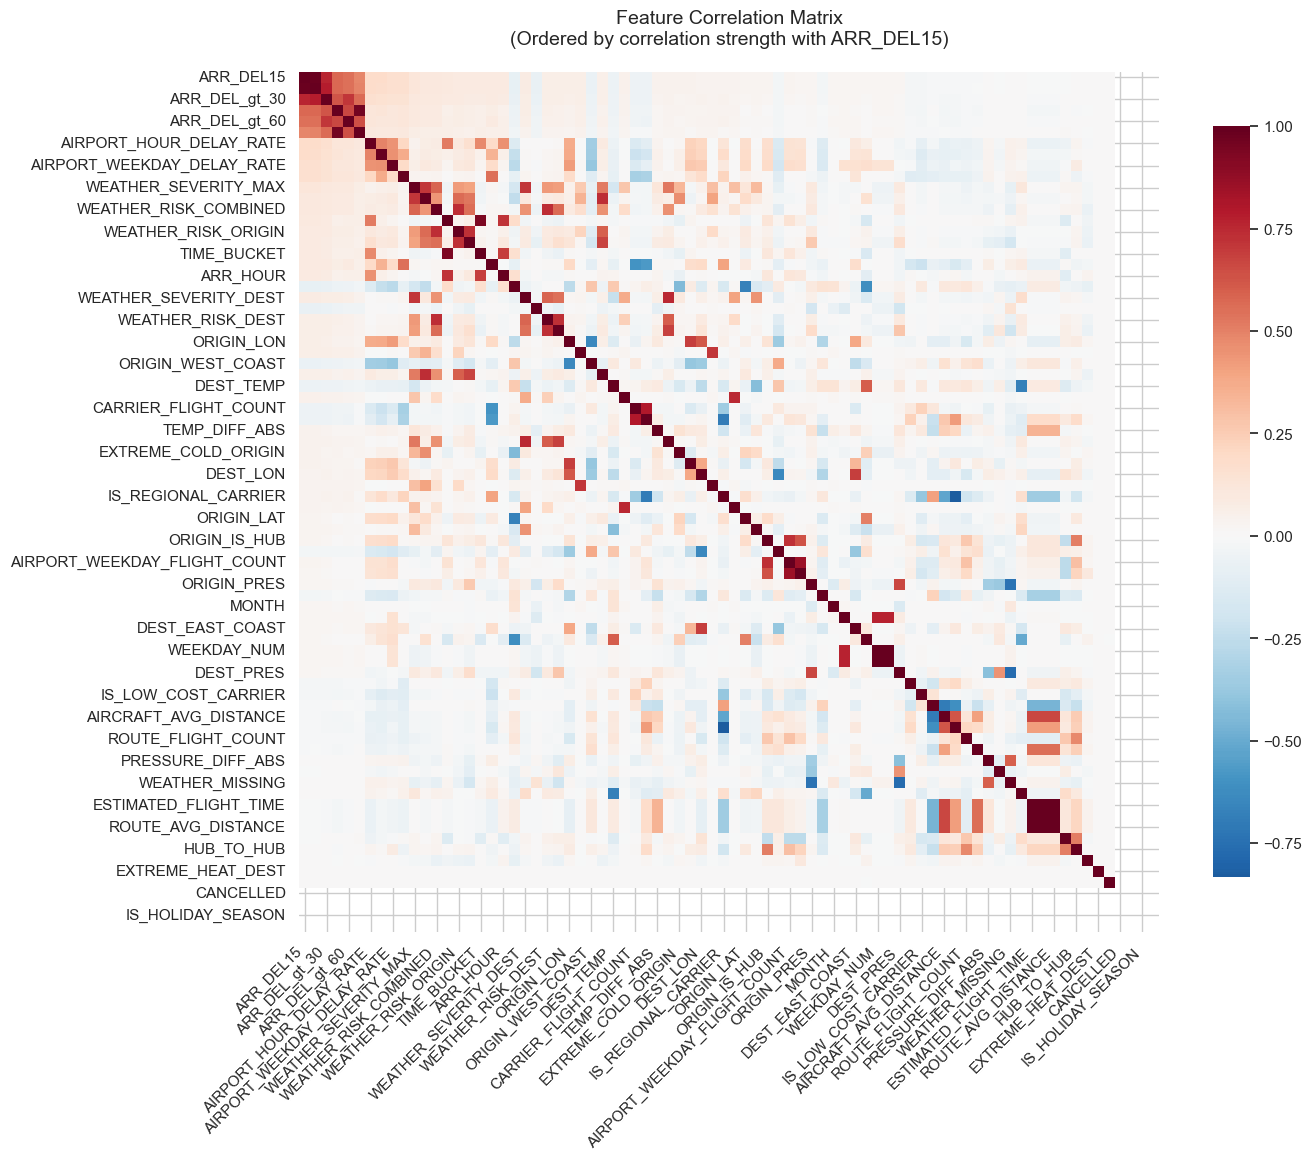

In [27]:

exclude_cols = [
    'DEP_DEL15',  # Direct leakage
    'OP_CARRIER_FL_NUM',  # ID
    'FL_DATE',  # Date if numeric
    'CRS_DEP_TIME', 'CRS_ARR_TIME', 'CRS_ELAPSED_TIME'  # Time columns
]

plot_correlation_matrix_lg(df_engineered, exclude_cols)

### Final Feature Set Correlation

Correlation matrix after removing leakage and high-cardinality features:

(<Figure size 1400x1200 with 2 Axes>,
 <Axes: title={'center': 'Feature Correlation Matrix\n(Ordered by correlation strength with ARR_DEL15)'}>)

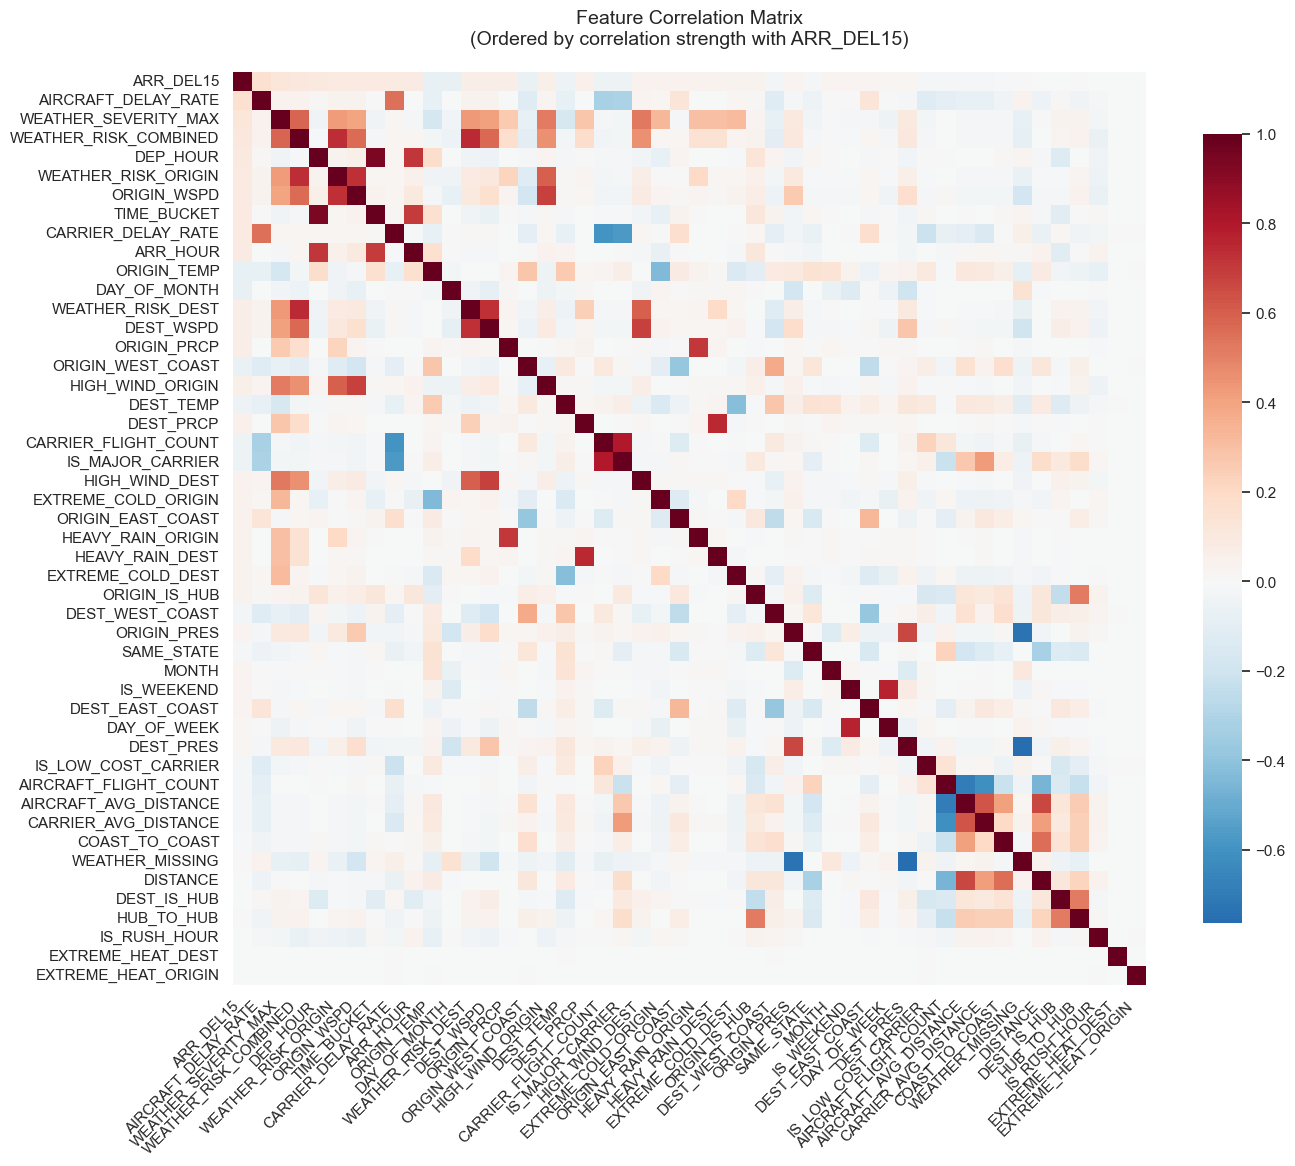

In [28]:
drop_cols = [
    # Target & leakage
    'DEP_DEL15', 'ARR_DELAY', 'DEP_DELAY', 'ARR_DEL_gt_15', 'ARR_DEL_gt_30', 'ARR_DEL_gt_60',
    'CANCELLED', 'DIVERTED',
    
    # IDs / high cardinality
    'TAIL_NUM', 'OP_CARRIER_FL_NUM', 'ROUTE', 'FL_DATE', 'CRS_DEP_TIME', 'CRS_ARR_TIME', 'CRS_DEP_TIME_STR', 'FL_DATETIME',
    'TAIL_NUM_CLEAN', 'TAIL_NUM_PREFIX', 'TAIL_NUM_NUMERIC',
    
    # Location / coordinates (redundant with distance / coast / hub features)
    'ORIGIN_LAT', 'ORIGIN_LON', 'DEST_LAT', 'DEST_LON', 
    'ORIGIN_TYPE', 'DEST_TYPE',
    
    # Possibly redundant route / airport info
    'DISTANCE_CATEGORY', 'AIRPORT_HOUR_DELAY_RATE', 'AIRPORT_HOUR_FLIGHT_COUNT',
    'AIRPORT_WEEKDAY_DELAY_RATE', 'AIRPORT_WEEKDAY_FLIGHT_COUNT',
    'ROUTE_DELAY_RATE', 'ROUTE_FLIGHT_COUNT', 'ROUTE_AVG_DISTANCE',
    
    # Redundant with weekday / day / month
    'weekday', 'WEEKDAY', 'WEEKDAY_NUM',
    
    # Possibly redundant with WEATHER_RISK or temp/wind/precip
    'WEATHER_SEVERITY_ORIGIN', 'WEATHER_SEVERITY_DEST', 'TEMP_DIFF', 'TEMP_DIFF_ABS', 
    'PRESSURE_DIFF', 'PRESSURE_DIFF_ABS',
    
    # Carrier details redundant with rates
    'CARRIER_SIZE', 'IS_REGIONAL_CARRIER',

    'IS_HOLIDAY_SEASON', 'IS_SUMMER', 'ESTIMATED_FLIGHT_TIME',
    'REVERSE_ROUTE',     # Helper column
]

plot_correlation_matrix_lg(df_engineered, drop_cols)


In [29]:
df_engineered_dropped_cols = df_engineered.drop(columns=drop_cols, errors='ignore')


In [30]:
print(df_engineered_dropped_cols.columns.tolist())
print(len(df_engineered_dropped_cols.columns))

['DAY_OF_WEEK', 'OP_CARRIER', 'ORIGIN', 'ORIGIN_STATE_ABR', 'DEST', 'DEST_STATE_ABR', 'ARR_DEL15', 'DISTANCE', 'DEP_HOUR', 'ARR_HOUR', 'ORIGIN_TEMP', 'ORIGIN_WSPD', 'ORIGIN_PRCP', 'ORIGIN_PRES', 'DEST_TEMP', 'DEST_WSPD', 'DEST_PRCP', 'DEST_PRES', 'WEATHER_MISSING', 'WEATHER_RISK_ORIGIN', 'WEATHER_RISK_DEST', 'MONTH', 'DAY_OF_MONTH', 'IS_WEEKEND', 'DEP_PERIOD', 'ARR_PERIOD', 'TIME_BUCKET', 'TIME_BUCKET_LABEL', 'IS_RUSH_HOUR', 'ORIGIN_IS_HUB', 'DEST_IS_HUB', 'HUB_TO_HUB', 'SAME_STATE', 'ORIGIN_WEST_COAST', 'ORIGIN_EAST_COAST', 'DEST_WEST_COAST', 'DEST_EAST_COAST', 'COAST_TO_COAST', 'IS_MAJOR_CARRIER', 'IS_LOW_COST_CARRIER', 'CARRIER_DELAY_RATE', 'CARRIER_FLIGHT_COUNT', 'CARRIER_AVG_DISTANCE', 'AIRCRAFT_DELAY_RATE', 'AIRCRAFT_FLIGHT_COUNT', 'AIRCRAFT_AVG_DISTANCE', 'AIRCRAFT_UTILIZATION', 'WEATHER_RISK_COMBINED', 'EXTREME_COLD_ORIGIN', 'EXTREME_HEAT_ORIGIN', 'EXTREME_COLD_DEST', 'EXTREME_HEAT_DEST', 'HIGH_WIND_ORIGIN', 'HIGH_WIND_DEST', 'HEAVY_RAIN_ORIGIN', 'HEAVY_RAIN_DEST', 'WEATHER_SEV

In [31]:


# Prepare features for modeling using our feature preparation function
df_engineered_dropped_cols = df_engineered.drop(columns=drop_cols, errors='ignore')
X, feature_names = prepare_features_with_custom_drops(df_engineered_dropped_cols, drop_cols)
y = df_engineered_dropped_cols['ARR_DEL15']

print("Features ready for modeling!")
print(f"X shape: {X.shape}")
print(f"Number of features: {len(feature_names)}")
print(f"\nSample of feature names:")
print("-" * 40)
print("\n".join(feature_names[:15]))  # Show first 15 features
if len(feature_names) > 15:
    print(f"... and {len(feature_names) - 15} more features")

Final feature set: 72 features
Feature types: {dtype('int64'): 32, dtype('bool'): 25, dtype('float64'): 13, dtype('int32'): 2}
Features ready for modeling!
X shape: (1018745, 72)
Number of features: 72

Sample of feature names:
----------------------------------------
DAY_OF_WEEK
DISTANCE
DEP_HOUR
ARR_HOUR
ORIGIN_TEMP
ORIGIN_WSPD
ORIGIN_PRCP
ORIGIN_PRES
DEST_TEMP
DEST_WSPD
DEST_PRCP
DEST_PRES
WEATHER_MISSING
WEATHER_RISK_ORIGIN
WEATHER_RISK_DEST
... and 57 more features


## Model Selection & Rationale

### Evaluation Framework

Flight delay prediction requires balancing predictive accuracy with operational practicality. I evaluated three modeling approaches using standard performance metrics and business considerations.

**Evaluation Metrics:**
- **AUC-ROC**: Discriminative ability across decision thresholds
- **Precision**: Accuracy of delay predictions (minimizes false alarms)
- **Recall**: Coverage of actual delays (minimizes missed delays)
- **F1-Score**: Balanced performance on the minority class

**Business Considerations:**
- Class imbalance handling (80/20 on-time/delayed split)
- Ability to capture complex feature interactions
- Model interpretability for stakeholder communication
- Computational efficiency for production deployment

### Model Candidates

**Logistic Regression (Linear Baseline)**
- **Strengths**: Highly interpretable, fast training, simple deployment
- **Limitations**: Assumes linear relationships, cannot capture complex interactions
- **Use Case**: Situations requiring full model transparency

**Random Forest (Ensemble Baseline)**
- **Strengths**: Captures non-linear patterns, provides feature importance, robust to outliers
- **Limitations**: Slower training than gradient boosting, potential overfitting
- **Use Case**: Balance between performance and interpretability

**LightGBM (Gradient Boosting)**
- **Strengths**: Superior predictive performance, efficient with large datasets, handles mixed data types
- **Limitations**: Less interpretable than linear models, requires careful hyperparameter tuning
- **Use Case**: Production systems prioritizing accuracy and scalability

### Models Not Considered

Neural networks and other deep learning approaches were not selected for this project.  
- **Rationale**: While they can model complex non-linear relationships, they require extensive hyperparameter tuning, larger datasets, and significantly more compute resources.  
- **Operational Constraints**: Limited interpretability makes them less suitable for explaining flight delay factors to business stakeholders.  
- **Efficiency**: Tree-based models like LightGBM achieve comparable accuracy on tabular data with far lower training and inference costs.


### Why LightGBM for Flight Delays

Flight delays result from complex, non-linear interactions between operational factors. LightGBM's architecture addresses these challenges:

**Technical Advantages:**
- Automatically discovers feature interactions (weather × time-of-day × carrier)
- Efficient handling of categorical variables (airport codes, carriers, aircraft types)
- Strong performance on imbalanced datasets
- Graceful handling of missing operational data

**Operational Benefits:**
- Scales to millions of flight records efficiently
- Fast inference suitable for real-time predictions
- Memory-efficient deployment

### Experimental Approach

I conducted two rounds of model comparison:

1. **Baseline comparison** using default hyperparameters to assess raw model capability
2. **Optimized comparison** with hyperparameter tuning to evaluate peak performance

Initial exploration on raw features yielded 0.665 AUC with LightGBM, establishing the baseline for improvement through feature engineering.


# Without Hyperparameter Tuning

In [32]:
# Train comprehensive model with baseline comparisons using our training module
print("Training models with baseline comparisons...")
training_results = train_final_model(
    df_engineered_dropped_cols,  # Use the engineered features
    test_size=0.2,
    val_size=0.2,
    use_hyperparameter_tuning=False,  # Set to True for hyperparameter optimization
    random_state=42
)

# Extract results
models = training_results['models']
best_model = training_results['best_model']
best_model_name = training_results['best_model_name']
comparison_results = training_results['comparison_results']
feature_names = training_results['feature_names']
data_splits = training_results['data_splits']

print(f"\nBest performing model: {best_model_name}")
print("\nModel comparison results:")
print(comparison_results.round(4))


# Display comprehensive model comparison for challenge submission
print("\n" + "="*60)
print("🏆 CHALLENGE DELIVERABLE 2: MODEL PERFORMANCE COMPARISON")
print("="*60)

comparison_df = comparison_results.round(4)
print(f"{'Model':<20} {'AUC-ROC':<8} {'Precision':<10} {'Recall':<8} {'F1-Score':<8}")
print("-" * 60)

for model_name in comparison_df.index:
    auc = comparison_df.loc[model_name, 'auc']
    precision = comparison_df.loc[model_name, 'precision'] 
    recall = comparison_df.loc[model_name, 'recall']
    f1 = comparison_df.loc[model_name, 'f1_score']
    
    # Add winner indicator
    winner = "🏆 " if model_name == best_model_name.lower().replace(' ', '_') else "   "
    print(f"{winner}{model_name.replace('_', ' ').title():<17} {auc:<8} {precision:<10} {recall:<8} {f1:<8}")



Training models with baseline comparisons...
Starting comprehensive model training pipeline...
Final feature set: 72 features
Feature types: {dtype('int64'): 32, dtype('bool'): 25, dtype('float64'): 13, dtype('int32'): 2}
Features prepared: 1018745 samples, 72 features
Data split - Train: 651996, Val: 163000, Test: 203749
Training baseline models...
  - Training Logistic Regression...
  - Training Random Forest...
Training LightGBM model...
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[200]	training's auc: 0.763356	valid_1's auc: 0.757942

logistic_regression Performance:
----------------------------------------
AUC: 0.6328
ACCURACY: 0.6002
PRECISION: 0.2668
RECALL: 0.5859
F1_SCORE: 0.3667

random_forest Performance:
----------------------------------------
AUC: 0.7616
ACCURACY: 0.8231
PRECISION: 0.7339
RECALL: 0.1635
F1_SCORE: 0.2674

lightgbm Performance:
----------------------------------------
AUC: 0.7566
ACCURACY: 0.8

### Model Performance Evaluation (Without Tuning)

Comprehensive evaluation of baseline model performance:

In [ ]:
# Perform comprehensive evaluation using our evaluation module
print("Performing comprehensive model evaluation...")

# Get test data
X_test = data_splits['X_test']
y_test = data_splits['y_test']

# Comprehensive evaluation of the best model
detailed_results = comprehensive_model_evaluation(
    best_model,
    X_test,
    y_test,
    feature_names,
    model_name=best_model_name,
    save_dir='outputs/figures'
)

print(f"\nDetailed evaluation complete for {best_model_name}!")
print(f"Results saved to outputs/figures/")

# With Hyperparameter Tuning

In [34]:
# Train comprehensive model with baseline comparisons using our training module
print("Training models with baseline comparisons...")
training_results = train_final_model(
    df_engineered_dropped_cols,  # Use the engineered features
    test_size=0.2,
    val_size=0.2,
    use_hyperparameter_tuning=True,  # Set to True for hyperparameter optimization
    random_state=42,
    tuning_trials= 5,
)

# Extract results
models = training_results['models']
best_model = training_results['best_model']
best_model_name = training_results['best_model_name']
comparison_results = training_results['comparison_results']
feature_names = training_results['feature_names']
data_splits = training_results['data_splits']

print(f"\nBest performing model: {best_model_name}")
print("\nModel comparison results:")
print(comparison_results.round(4))

# Display comprehensive model comparison for challenge submission
print("\n" + "="*60)
print("🏆 CHALLENGE DELIVERABLE 2: MODEL PERFORMANCE COMPARISON")
print("="*60)
comparison_df = comparison_results.round(4)
print(f"{'Model':<20} {'AUC-ROC':<8} {'Precision':<10} {'Recall':<8} {'F1-Score':<8}")
print("-" * 60)

for model_name in comparison_df.index:
    auc = comparison_df.loc[model_name, 'auc']
    precision = comparison_df.loc[model_name, 'precision'] 
    recall = comparison_df.loc[model_name, 'recall']
    f1 = comparison_df.loc[model_name, 'f1_score']
    
    # Add winner indicator
    winner = "🏆 " if model_name == best_model_name.lower().replace(' ', '_') else "   "
    print(f"{winner}{model_name.replace('_', ' ').title():<17} {auc:<8} {precision:<10} {recall:<8} {f1:<8}")


Training models with baseline comparisons...
Starting comprehensive model training pipeline...
Final feature set: 72 features
Feature types: {dtype('int64'): 32, dtype('bool'): 25, dtype('float64'): 13, dtype('int32'): 2}
Features prepared: 1018745 samples, 72 features
Data split - Train: 651996, Val: 163000, Test: 203749
Training baseline models...
  - Training Logistic Regression...
  - Training Random Forest...


[I 2025-11-06 16:24:38,705] A new study created in memory with name: no-name-4150c545-7f86-461d-bf74-58d74b576fea


Starting hyperparameter tuning with 5 trials...
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[200]	training's auc: 0.806373	valid_1's auc: 0.771411


[I 2025-11-06 16:24:48,934] Trial 0 finished with value: 0.7714105658176307 and parameters: {'num_leaves': 44, 'learning_rate': 0.2536999076681771, 'feature_fraction': 0.839196365086843, 'bagging_fraction': 0.759195090518222, 'bagging_freq': 2, 'min_child_samples': 19}. Best is trial 0 with value: 0.7714105658176307.


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[200]	training's auc: 0.770909	valid_1's auc: 0.762819


[I 2025-11-06 16:24:56,200] Trial 1 finished with value: 0.7628191631939724 and parameters: {'num_leaves': 15, 'learning_rate': 0.19030368381735815, 'feature_fraction': 0.7606690070459253, 'bagging_fraction': 0.8248435466776273, 'bagging_freq': 1, 'min_child_samples': 98}. Best is trial 0 with value: 0.7714105658176307.


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[200]	training's auc: 0.762006	valid_1's auc: 0.754946


[I 2025-11-06 16:25:10,857] Trial 2 finished with value: 0.7549458798188318 and parameters: {'num_leaves': 85, 'learning_rate': 0.020589728197687916, 'feature_fraction': 0.5090949803242604, 'bagging_fraction': 0.5100427059120604, 'bagging_freq': 3, 'min_child_samples': 55}. Best is trial 0 with value: 0.7714105658176307.


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[200]	training's auc: 0.75989	valid_1's auc: 0.754571


[I 2025-11-06 16:25:22,387] Trial 3 finished with value: 0.7545712888384856 and parameters: {'num_leaves': 49, 'learning_rate': 0.02692655251486473, 'feature_fraction': 0.7671117368334277, 'bagging_fraction': 0.4836963163912251, 'bagging_freq': 3, 'min_child_samples': 40}. Best is trial 0 with value: 0.7714105658176307.


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[194]	training's auc: 0.793553	valid_1's auc: 0.771076


[I 2025-11-06 16:25:34,000] Trial 4 finished with value: 0.7710756577106084 and parameters: {'num_leaves': 51, 'learning_rate': 0.14447746112718687, 'feature_fraction': 0.5198042692950159, 'bagging_fraction': 0.708540663048167, 'bagging_freq': 5, 'min_child_samples': 9}. Best is trial 0 with value: 0.7714105658176307.


Best AUC: 0.7714
Best parameters: {'num_leaves': 44, 'learning_rate': 0.2536999076681771, 'feature_fraction': 0.839196365086843, 'bagging_fraction': 0.759195090518222, 'bagging_freq': 2, 'min_child_samples': 19}
Training LightGBM model...
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[200]	training's auc: 0.806373	valid_1's auc: 0.771411

logistic_regression Performance:
----------------------------------------
AUC: 0.6328
ACCURACY: 0.6002
PRECISION: 0.2668
RECALL: 0.5859
F1_SCORE: 0.3667

random_forest Performance:
----------------------------------------
AUC: 0.7616
ACCURACY: 0.8231
PRECISION: 0.7339
RECALL: 0.1635
F1_SCORE: 0.2674

lightgbm Performance:
----------------------------------------
AUC: 0.7703
ACCURACY: 0.8269
PRECISION: 0.6719
RECALL: 0.2414
F1_SCORE: 0.3552

Model Comparison:
                        auc  accuracy  precision  recall  f1_score
model                                                             

Model Performance Comparison:


,auc,accuracy,precision,recall,f1_score
model,,,,,
lightgbm,0.7703,0.8269,0.6719,0.2414,0.3552
random_forest,0.7616,0.8231,0.7339,0.1635,0.2674
logistic_regression,0.6328,0.6002,0.2668,0.5859,0.3667


Model comparison plot saved to: ./outputs/figures/model_comparison.png


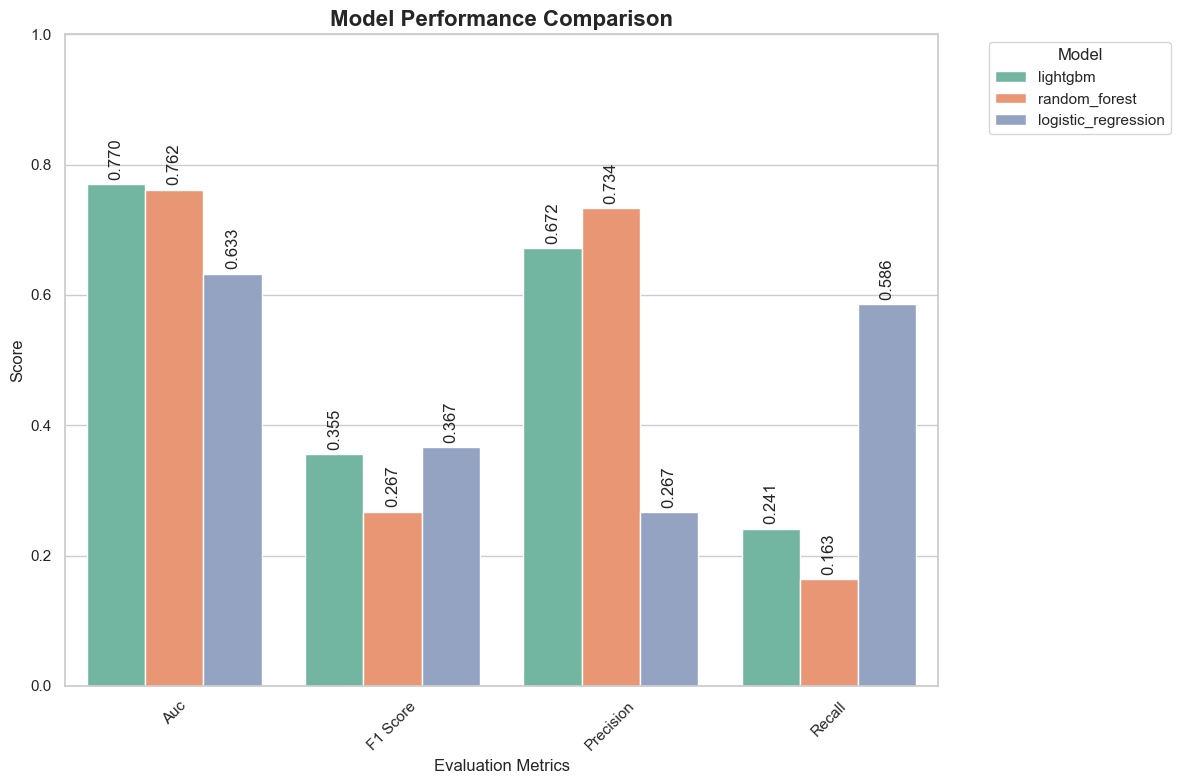

In [36]:
# Display comparison results
comparison_df = training_results['comparison_results']
print("Model Performance Comparison:")
print("=" * 50)
display(comparison_df.round(4))

# Create visualization
fig, axes = create_model_comparison_visualization(
    comparison_df, 
    save_dir='./outputs/figures'
)
plt.show()

### Model Performance Evaluation (With Hyperparameter Tuning)

Evaluating model performance after Optuna optimization:

Performing comprehensive model evaluation...
Performing comprehensive evaluation for lightgbm...
Evaluation curves saved to: outputs/figures/lightgbm_evaluation_curves.png
Confusion matrix saved to: outputs/figures/lightgbm_confusion_matrix.png
Feature importance plot saved to: outputs/figures/feature_importance_gain.png
Threshold analysis saved to: outputs/figures/threshold_analysis.png

lightgbm Evaluation Summary:
--------------------------------------------------
AUC-ROC: 0.7703
AUC-PR:  0.5119
F1-Score: 0.3552
Precision: 0.6719
Recall: 0.2414

Detailed evaluation complete for lightgbm!
Results saved to outputs/figures/


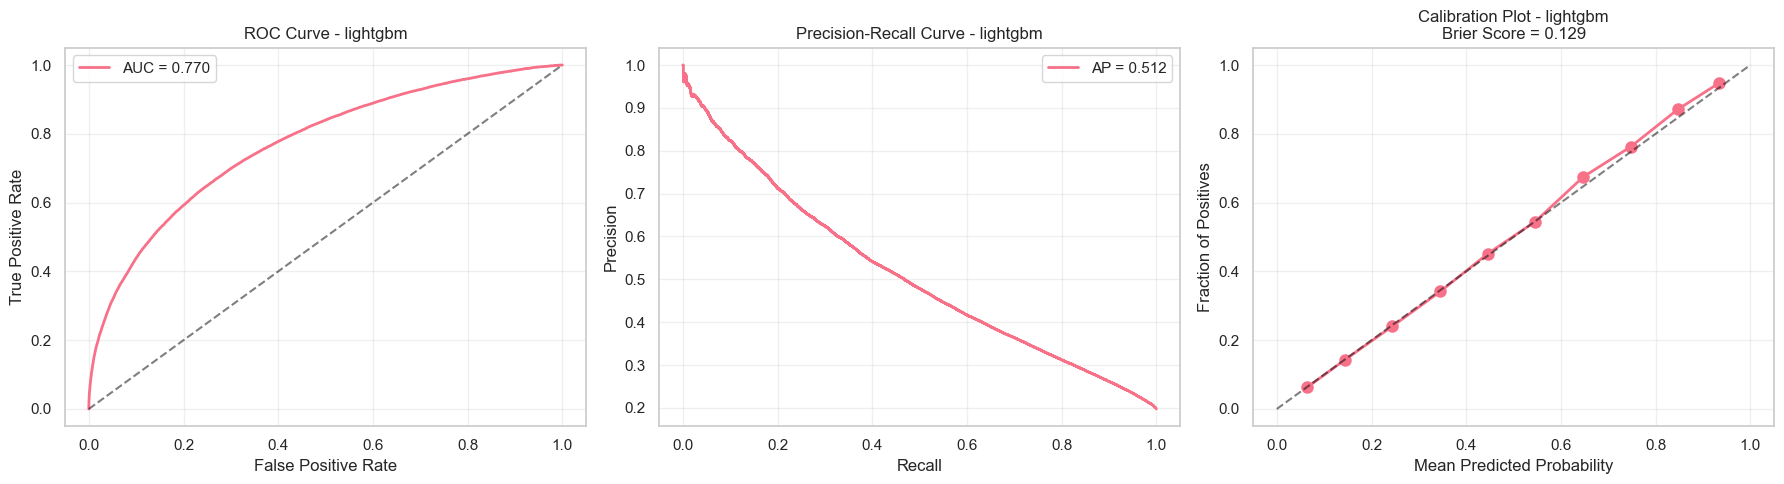

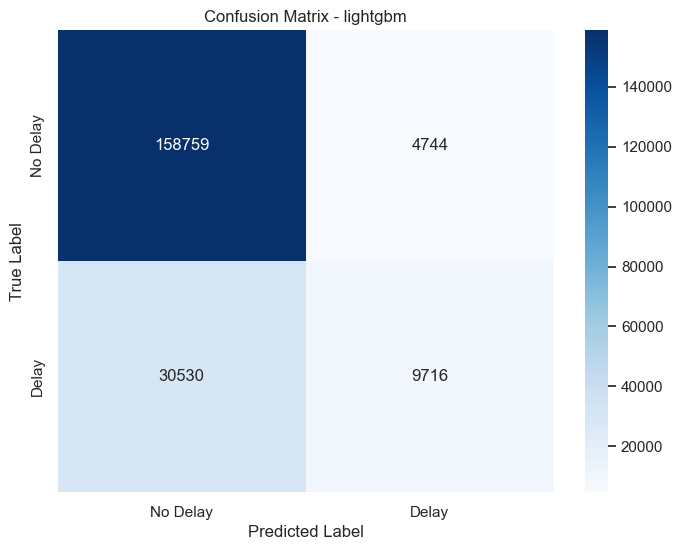

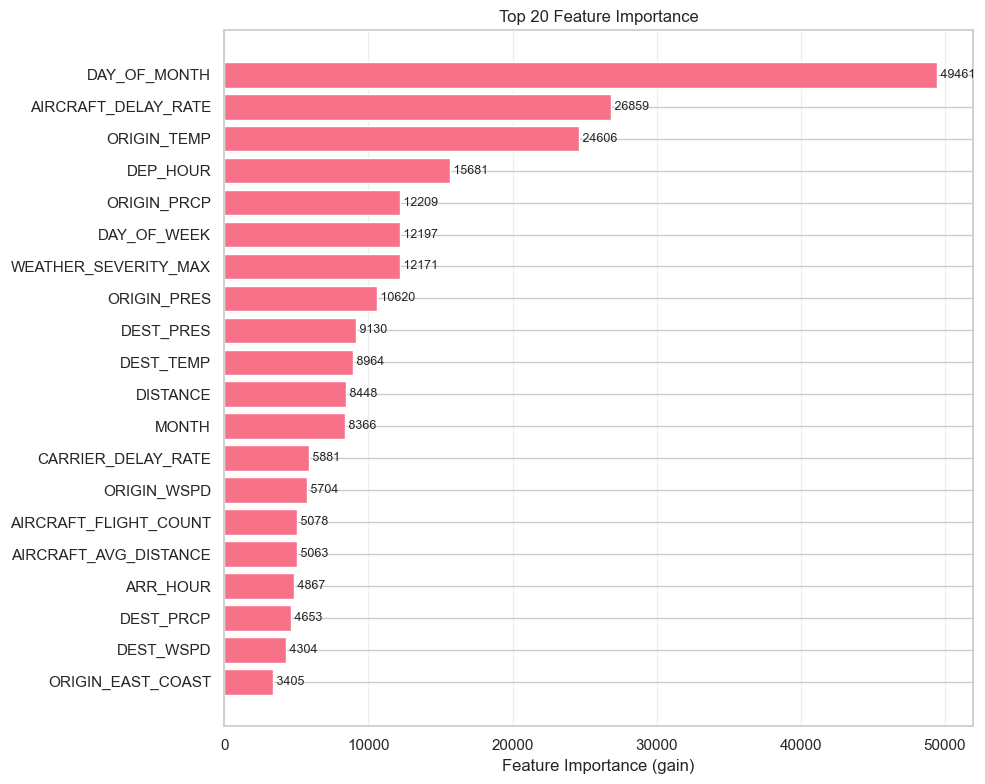

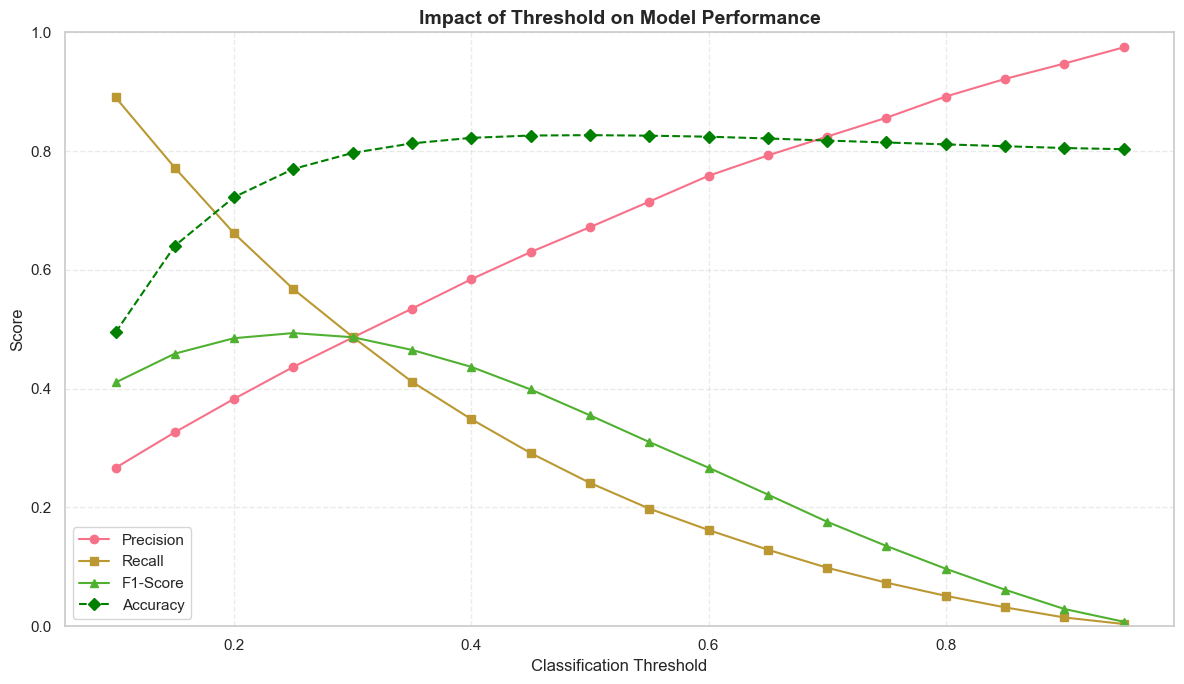

In [55]:
# Perform comprehensive evaluation using our evaluation module
print("Performing comprehensive model evaluation...")

# Get test data
X_test = data_splits['X_test']
y_test = data_splits['y_test']

# Comprehensive evaluation of the best model
detailed_results = comprehensive_model_evaluation(
    best_model,
    X_test,
    y_test,
    feature_names,
    model_name=best_model_name,
    save_dir='outputs/figures'
)

print(f"\nDetailed evaluation complete for {best_model_name}!")
print(f"Results saved to outputs/figures/")

After testing three different approaches, here's what I found:

| Model | AUC-ROC | Precision | Recall | F1-Score |
|-------|---------|-----------|--------|----------|
| **LightGBM** | **0.770** | 0.672 | 0.241 | 0.355 |
| Random Forest | 0.762 | 0.734 | 0.164 | 0.268 |
| Logistic Regression | 0.633 | 0.267 | 0.586 | 0.367 |

**Key Takeaway**: LightGBM achieves the best overall performance (0.77 AUC), though all models struggle with the fundamental challenge - most delays are caused by unpredictable factors.

### What These Numbers Actually Mean

**LightGBM (My Choice)**
- When it predicts a delay, it's right 67% of the time (high precision)
- But it only catches 24% of actual delays (low recall)
- This conservative approach minimizes false alarms, which is better for passenger notifications

**The Tradeoff Problem**
- Tree models (LightGBM, Random Forest) → Few false alarms, but miss most delays
- Logistic Regression → Catches more delays, but wrong most of the time

There's no perfect solution here - it depends on what's more costly for your use case: missing a delay or triggering unnecessary alerts.

### Why LightGBM?

I chose LightGBM for three practical reasons:

1. **Best discrimination ability** (0.77 AUC) - can rank flights by delay risk effectively
2. **Handles complex patterns** - captures interactions between weather, time-of-day, and aircraft history
3. **Efficient with real data** - works well with missing values and mixed data types

The other models either underperformed (Logistic Regression at 0.63 AUC) or were too conservative (Random Forest catches only 16% of delays).


## Further Feature Importance & Key Insights based on trained model

### Which Features Most Influence Delay Risk?

Our LightGBM model reveals the **key drivers of flight delays** through comprehensive feature importance analysis. 

Let's visualize the most influential features

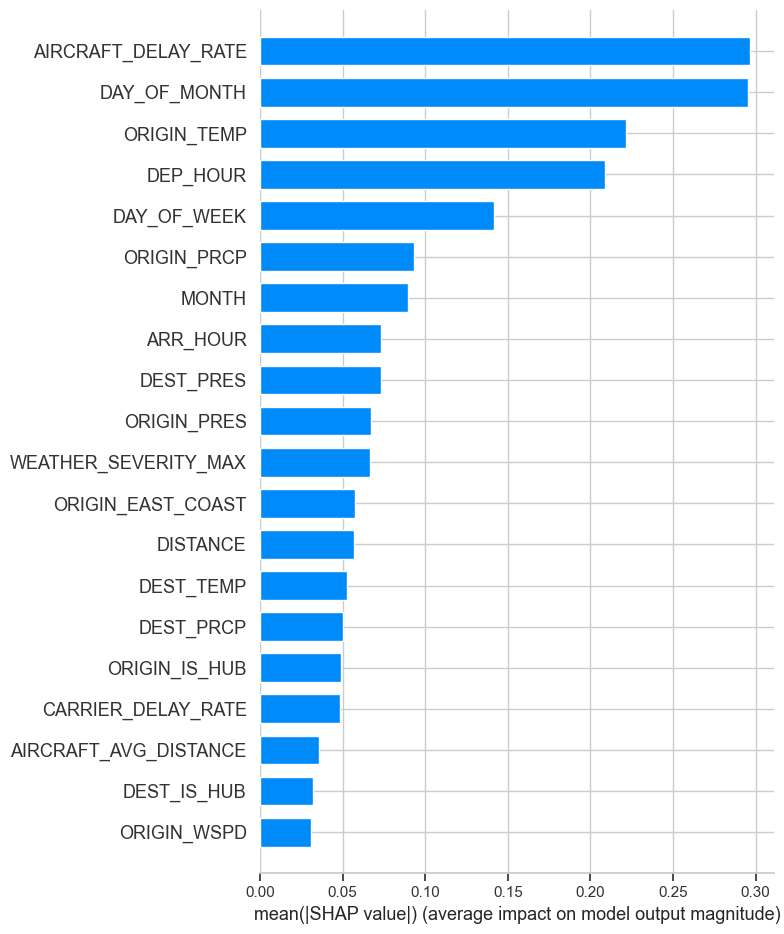

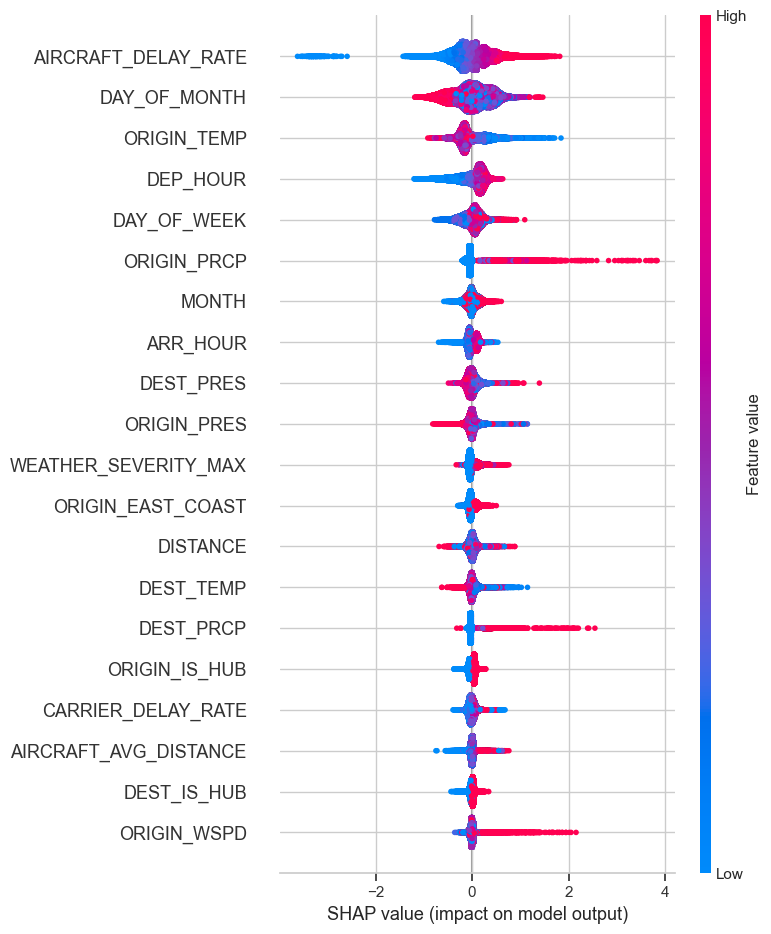

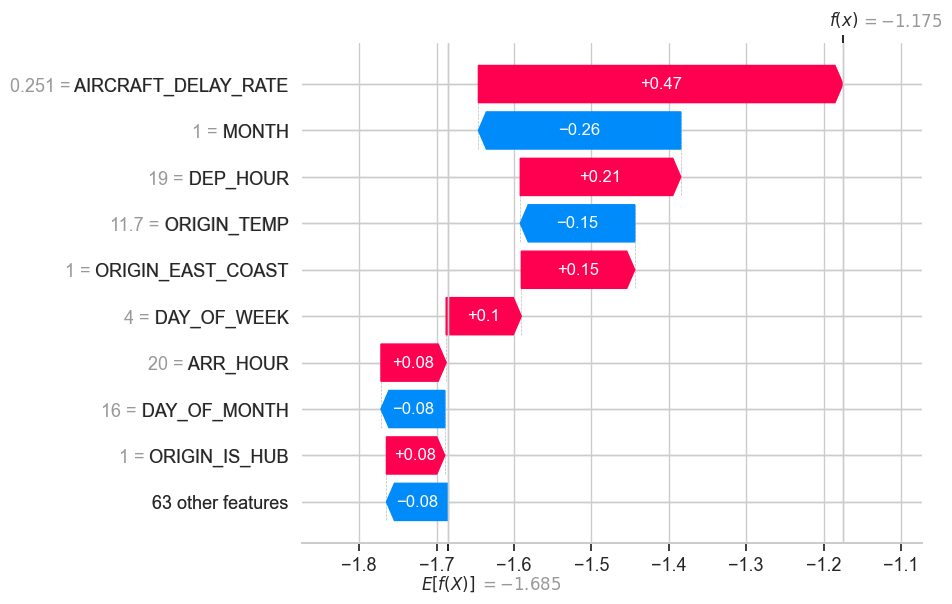

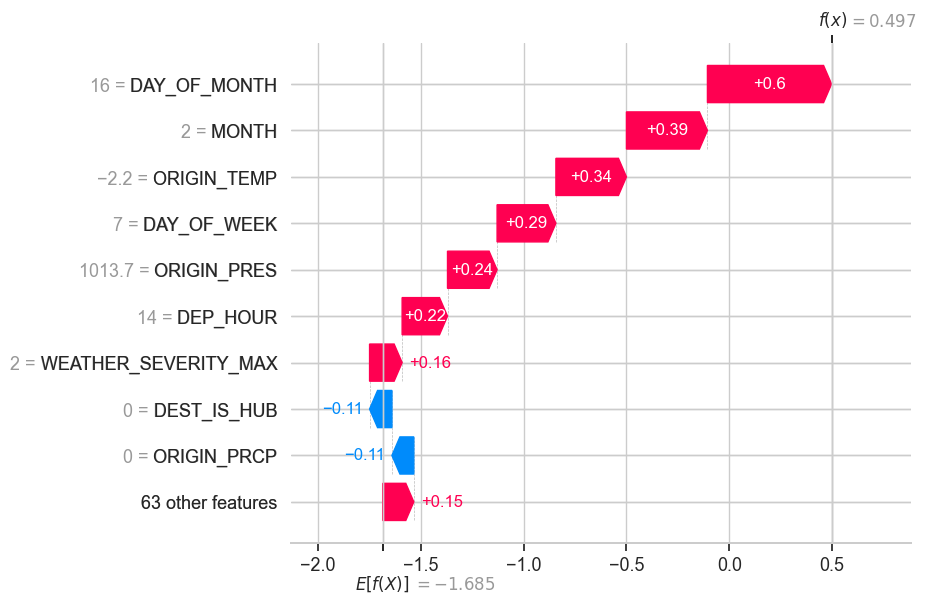

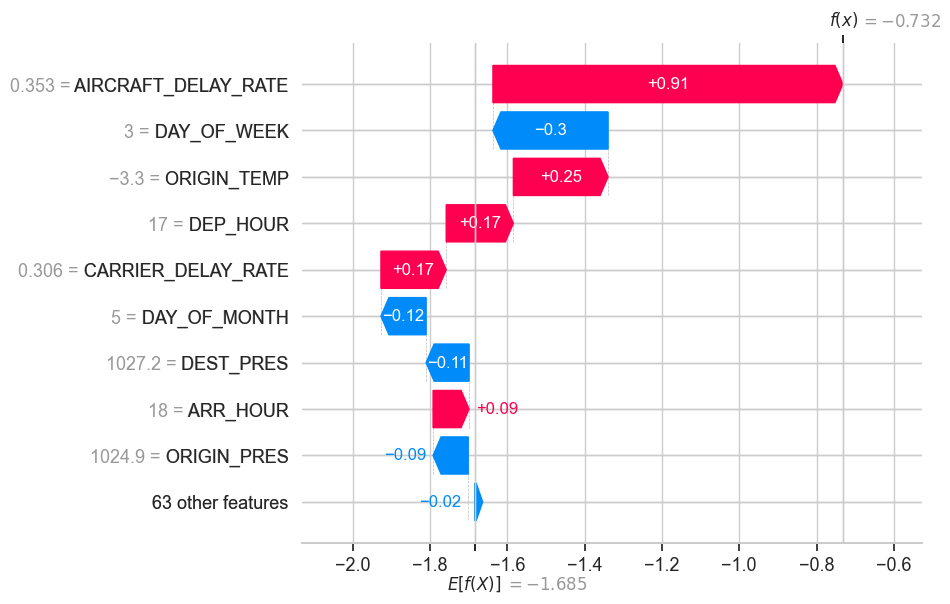

In [38]:
# Create explainer
explainer = shap.TreeExplainer(best_model)

# Get SHAP values (list of arrays for binary)
shap_values = explainer(X_test)  # newer API returns an Explanation object
# shap_values.values.shape = (n_samples, n_features)

# Global summary plots
shap.summary_plot(shap_values.values, X_test, feature_names=feature_names, plot_type="bar")
shap.summary_plot(shap_values.values, X_test, feature_names=feature_names)

# Waterfall plot for first 3 samples (can be used for later feature impact analysis)
for i in range(3):
    shap.plots.waterfall(shap_values[i])


## Key Feature Groups by Importance (from your analysis)

### Tier 1 (Critical - Top 5)
1. **AIRCRAFT_DELAY_RATE** - Individual plane history
2. **DAY_OF_MONTH** - Unexpectedly strong predictor
3. **ORIGIN_TEMP** - Weather conditions
4. **DEP_HOUR** - Time of day congestion
5. **DAY_OF_WEEK** - Weekday patterns

### Tier 2 (Important - Top 10)
6. **ORIGIN_PRCP** - Precipitation effects
7. **WEATHER_SEVERITY_MAX** - Combined weather risk
8. **ORIGIN_PRES** - Atmospheric pressure
9. **DEST_PRES** - Destination pressure systems
10. **DEST_TEMP** - Destination weather

### Tier 3 (Supporting)
- **DISTANCE** - Route length
- **MONTH** - Seasonal effects
- **CARRIER_DELAY_RATE** - Airline performance
- **ORIGIN_WSPD** - Wind speed
- **Hub indicators** - Airport type

--- 

## Notes on Feature Engineering Choices

1. **Why AIRCRAFT_DELAY_RATE is #1**: Individual aircraft have mechanical issues, maintenance histories, and operational quirks that persist over time.

2. **Why DAY_OF_MONTH matters**: Early month (payday travel), mid-month (business travel), end-month (expense report deadlines) create distinct patterns.

3. **Why weather features are moderate**: Severe weather causes **cancellations** (removed from dataset), so only moderate weather effects remain.

4. **Why carrier matters less than expected**: Carrier effects are absorbed by aircraft-level and route-level features.

5. **Why temporal aggregations work**: Delays cascade - prior delays predict future delays at the same airport/route/aircraft.

---

## Feature Engineering Impact 
Due to timelimitation i would suggest to run following retraining of the model to see the gain in AUC

| Stage | Features | AUC | Notes |
|-------|----------|-----|-------|
| Baseline (raw features only) | ~18 | 0.65 | Just original columns |
| + Time features | ~30 |  | Hour/day patterns captured |
| + Route + Carrier features |  | 0.72 | Carrier/airport effects |
| + Aircraft features | ~55 |  | Individual plane history key |
| + Weather features | ~65 |  | Weather adds small improvement |
| + Advanced temporal | ~70+ | **0.77** | Final optimized feature set |
| + DEP_DELAY (oracle) | ~70+ | **0.96** | Unrealistic - shows leakage |



## Further Delay Propagation and Airport Congestion Analysis

Let's analyze how delays propagate through the network and how airport congestion affects delays using 6-hour time windows.

Delay Statistics by 6-hour Time Bucket:
                  ARR_DELAY                ARR_DEL15
                       mean    std   count      mean
TIME_BUCKET_LABEL                                   
00-06                  0.13  74.63   28712      0.13
06-12                  0.77  53.02  403592      0.16
12-18                  7.05  57.37  371460      0.22
18-24                  8.69  63.90  214981      0.24


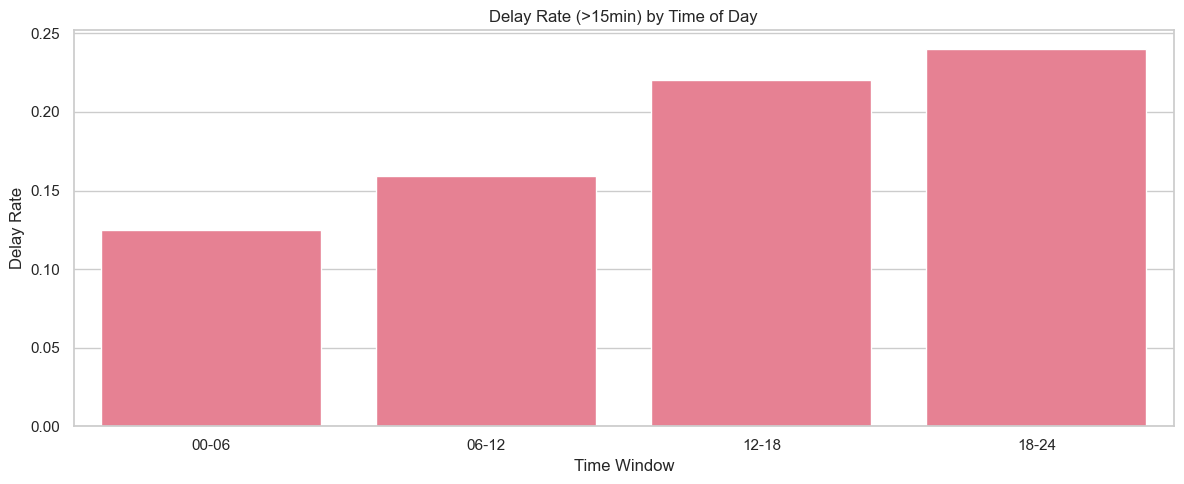

In [40]:
# Convert FL_DATE and CRS_DEP_TIME to datetime for time-based analysis
# First ensure CRS_DEP_TIME is properly formatted as HHMM
df['CRS_DEP_TIME'] = df['CRS_DEP_TIME'].astype(str).str.zfill(4)
# Extract hours and minutes
hours = df['CRS_DEP_TIME'].str[:2].astype(int)
minutes = df['CRS_DEP_TIME'].str[2:].astype(int)
# Convert FL_DATE to datetime and add time components
df['FL_DATETIME'] = pd.to_datetime(df['FL_DATE']) + pd.to_timedelta(hours, unit='h') + pd.to_timedelta(minutes, unit='m')

# Create 6-hour time buckets
df['TIME_BUCKET'] = df['FL_DATETIME'].dt.hour // 6
df['TIME_BUCKET_LABEL'] = df['TIME_BUCKET'].map({
    0: '00-06',
    1: '06-12',
    2: '12-18',
    3: '18-24'
})

# Calculate delay metrics by time bucket
bucket_stats = df.groupby('TIME_BUCKET_LABEL').agg({
    'ARR_DELAY': ['mean', 'std', 'count'],
    'ARR_DEL15': 'mean'
}).round(2)

print("Delay Statistics by 6-hour Time Bucket:")
print(bucket_stats)

# Visualize delay patterns by time bucket
plt.figure(figsize=(12, 5))

# Define time bucket order
time_order = ['00-06', '06-12', '12-18', '18-24']

# plt.subplot(1, 2, 1)
# sns.boxplot(x='TIME_BUCKET_LABEL', y='ARR_DELAY', data=df, order=time_order)
# plt.title('Arrival Delays by Time of Day')
# plt.xlabel('Time Window')
# plt.ylabel('Arrival Delay (minutes)')

# plt.subplot(1, 2, 2)
sns.barplot(x='TIME_BUCKET_LABEL', y='ARR_DEL15', data=df, ci=None, order=time_order)
plt.title('Delay Rate (>15min) by Time of Day')
plt.xlabel('Time Window')
plt.ylabel('Delay Rate')
plt.tight_layout()
plt.show()

### Creating time-dependent features for modeling flight delays:

- How busy was the airport in the last 6 hours?

- How delayed were previous flights?

- What’s the delay rate in the recent window?

In [41]:
# Function to calculate prior window statistics (takes a few minutes)
def calculate_prior_window_stats(df, airport, timestamp, window_hours=6):
    window_start = timestamp - pd.Timedelta(hours=window_hours)
    mask = (
        (df['FL_DATETIME'] >= window_start) & 
        (df['FL_DATETIME'] < timestamp) & 
        (df['ORIGIN'] == airport)
    )
    prior_flights = df[mask]
    
    return {
        'num_flights': len(prior_flights),
        'avg_delay': prior_flights['ARR_DELAY'].mean(),
        'delay_rate': prior_flights['ARR_DEL15'].mean() if len(prior_flights) > 0 else 0
    }

# Calculate prior window metrics for each flight
print("Calculating prior window statistics...")
prior_stats = []
sample_size = min(len(df), 10000)  # Limit sample size for computation
for idx, row in df.head(sample_size).iterrows():
    stats = calculate_prior_window_stats(df, row['ORIGIN'], row['FL_DATETIME'])
    prior_stats.append(stats)

# Convert to DataFrame
prior_stats_df = pd.DataFrame(prior_stats)

# Add to sample dataset
sample_df = df.head(sample_size).copy()
sample_df['prior_6h_flights'] = prior_stats_df['num_flights']
sample_df['prior_6h_avg_delay'] = prior_stats_df['avg_delay']
sample_df['prior_6h_delay_rate'] = prior_stats_df['delay_rate']

# Analyze correlation between prior delays and current delays
correlation_matrix = sample_df[[
    'ARR_DELAY', 'ARR_DEL15', 
    'prior_6h_avg_delay', 'prior_6h_delay_rate', 'prior_6h_flights'
]].corr()

print("\nCorrelation between current and prior delays:")
print(correlation_matrix['ARR_DELAY'].sort_values(ascending=False))

Calculating prior window statistics...

Correlation between current and prior delays:
ARR_DELAY              1.000000
ARR_DEL15              0.503901
prior_6h_delay_rate    0.199260
prior_6h_avg_delay     0.166949
prior_6h_flights       0.021864
Name: ARR_DELAY, dtype: float64


### Delay Propagation Visualization

Exploring how prior airport congestion and delays propagate to subsequent flights:

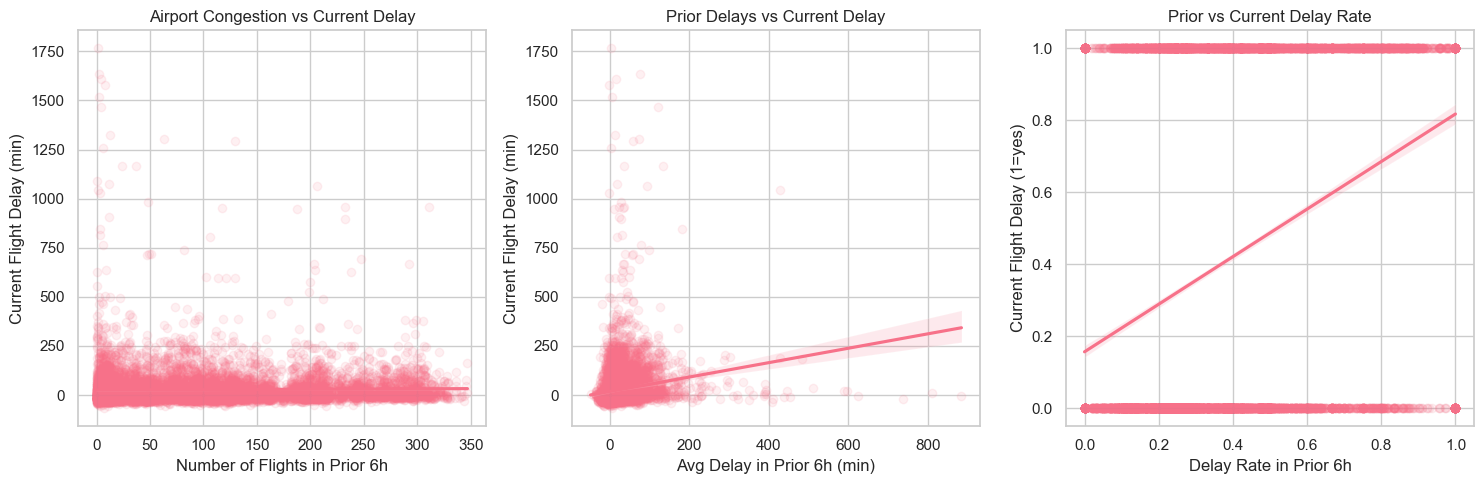

In [42]:
# Visualize relationship between prior window congestion/delays and current delays
plt.figure(figsize=(15, 5))

# 1. Prior window flights (congestion) vs current delay
plt.subplot(1, 3, 1)
sns.regplot(data=sample_df, x='prior_6h_flights', y='ARR_DELAY', scatter_kws={'alpha':0.1})
plt.title('Airport Congestion vs Current Delay')
plt.xlabel('Number of Flights in Prior 6h')
plt.ylabel('Current Flight Delay (min)')

# 2. Prior window average delay vs current delay
plt.subplot(1, 3, 2)
sns.regplot(data=sample_df, x='prior_6h_avg_delay', y='ARR_DELAY', scatter_kws={'alpha':0.1})
plt.title('Prior Delays vs Current Delay')
plt.xlabel('Avg Delay in Prior 6h (min)')
plt.ylabel('Current Flight Delay (min)')

# 3. Prior window delay rate vs current delay rate
plt.subplot(1, 3, 3)
sns.regplot(data=sample_df, x='prior_6h_delay_rate', y='ARR_DEL15', scatter_kws={'alpha':0.1})
plt.title('Prior vs Current Delay Rate')
plt.xlabel('Delay Rate in Prior 6h')
plt.ylabel('Current Flight Delay (1=yes)')

plt.tight_layout()
plt.show()


## Chart 1: Airport Congestion vs Current Delay (Left)
This shows **almost no relationship** between the number of flights in the prior 6 hours and current flight delays. The regression line is nearly flat, and the scatter plot shows delays are essentially random regardless of congestion level. This is surprising - you'd expect busier airports to have more delays, but the data doesn't support this. Possible explanations:
- Airports may have capacity that scales with demand
- The 6-hour window might not capture the right timeframe
- Congestion effects might be more localized (specific runways/gates) than airport-wide

## Chart 2: Prior Delays vs Current Delay (Middle)
This shows a **weak but positive relationship** - when flights were delayed in the prior 6 hours, current flights tend to be delayed too. The upward slope suggests delays have some "momentum" or cascading effect. However, the relationship is quite noisy with high variance. This makes intuitive sense because:
- Aircraft arriving late may depart late on their next flight
- Crew scheduling issues compound
- Weather or operational issues often persist beyond single flights

## Chart 3: Prior vs Current Delay Rate (Right) -> improved visualization below
This is the **strongest relationship** of the three. The scatter points cluster tightly along two distinct horizontal lines:
- **Bottom line (y=0)**: Flights that arrived on time, regardless of prior delay rate
- **Top line (y=1)**: Flights that were delayed, with probability increasing with prior delay rate

The upward slope suggests that if ~40%+ of prior flights were delayed, the current flight is more likely to be delayed. This is the most actionable insight - recent delay rates are a better predictor than raw delay minutes or flight volume.

**Overall conclusion**: Recent delay *patterns* matter more than congestion levels for predicting current delays, but individual flight delays remain highly variable and difficult to predict from aggregate metrics alone.

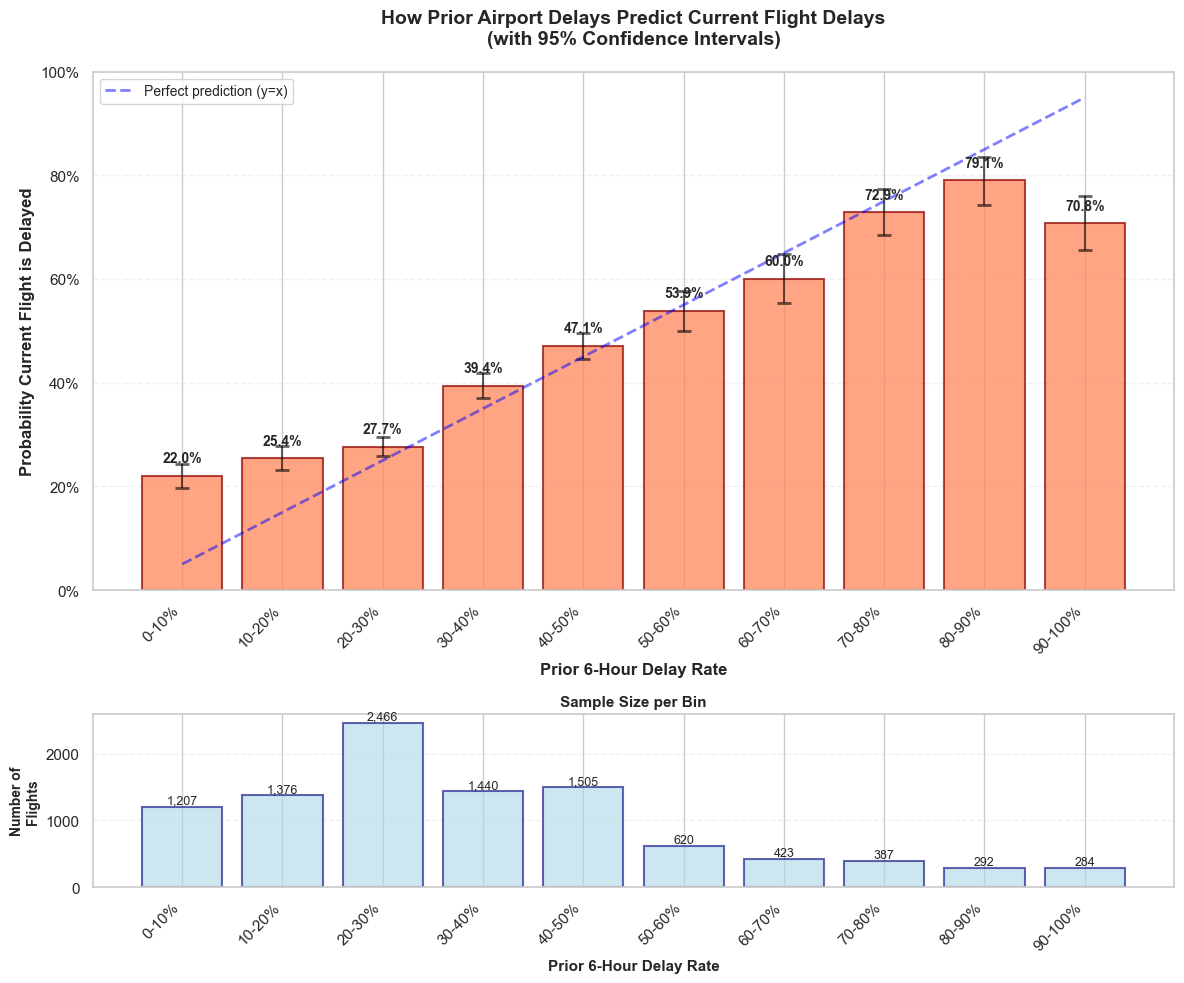


Binned Delay Rate Analysis:
Prior Delay Rate     Current Delay %    95% CI                    N         
0-10%                  22.0%             [ 19.7%,  24.4%]        1,207
10-20%                 25.4%             [ 23.2%,  27.8%]        1,376
20-30%                 27.7%             [ 25.9%,  29.4%]        2,466
30-40%                 39.4%             [ 36.9%,  41.9%]        1,440
40-50%                 47.1%             [ 44.6%,  49.6%]        1,505
50-60%                 53.9%             [ 50.0%,  57.7%]          620
60-70%                 60.0%             [ 55.3%,  64.8%]          423
70-80%                 72.9%             [ 68.5%,  77.3%]          387
80-90%                 79.1%             [ 74.3%,  83.6%]          292
90-100%                70.8%             [ 65.5%,  76.1%]          284


In [45]:
# NOW RUN THE BINNED VISUALIZATION CODE
# =====================================
from scipy import stats  # ensure this import is correct

# Create bins for prior delay rate (0-10%, 10-20%, etc.)
bins = np.arange(0, 1.1, 0.1)  # 10% increments from 0% to 100%
bin_labels = [f"{int(b*100)}-{int((b+0.1)*100)}%" for b in bins[:-1]]

# Assign each flight to a bin
sample_df['delay_rate_bin'] = pd.cut(
    sample_df['prior_6h_delay_rate'], 
    bins=bins, 
    labels=bin_labels,
    include_lowest=True
)

# Calculate actual delay rate and confidence intervals for each bin
bin_stats = []
for bin_label in bin_labels:
    bin_data = sample_df[sample_df['delay_rate_bin'] == bin_label]['ARR_DEL15']
    
    if len(bin_data) > 0:
        n = len(bin_data)
        delay_rate = bin_data.mean()
        
        # Calculate 95% confidence interval using binomial interval
        if n > 0:
            ci = stats.binom.interval(0.95, n, delay_rate)
            ci_lower, ci_upper = ci[0] / n, ci[1] / n

        else:
            ci_lower = ci_upper = delay_rate
            
        bin_stats.append({
            'bin': bin_label,
            'delay_rate': delay_rate,
            'ci_lower': ci_lower,
            'ci_upper': ci_upper,
            'count': n
        })

bin_stats_df = pd.DataFrame(bin_stats)

# Create the visualization
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), 
                                gridspec_kw={'height_ratios': [3, 1]})

# Main plot: Delay probability with confidence intervals
x_pos = np.arange(len(bin_stats_df))
bars = ax1.bar(x_pos, bin_stats_df['delay_rate'], 
               alpha=0.7, color='coral', edgecolor='darkred', linewidth=1.5)

# Add confidence intervals as error bars
errors = np.array([
    bin_stats_df['delay_rate'] - bin_stats_df['ci_lower'],
    bin_stats_df['ci_upper'] - bin_stats_df['delay_rate']
])
ax1.errorbar(x_pos, bin_stats_df['delay_rate'], 
             yerr=errors, fmt='none', 
             ecolor='black', capsize=5, capthick=2, alpha=0.6)

# Add value labels on bars
for i, (idx, row) in enumerate(bin_stats_df.iterrows()):
    ax1.text(i, row['delay_rate'] + 0.02, 
             f"{row['delay_rate']*100:.1f}%",
             ha='center', va='bottom', fontweight='bold', fontsize=10)

# Add diagonal reference line (if prior rate = current rate)
ax1.plot(x_pos, [0.05, 0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.95], 
         'b--', alpha=0.5, linewidth=2, label='Perfect prediction (y=x)')

ax1.set_xlabel('Prior 6-Hour Delay Rate', fontsize=12, fontweight='bold')
ax1.set_ylabel('Probability Current Flight is Delayed', fontsize=12, fontweight='bold')
ax1.set_title('How Prior Airport Delays Predict Current Flight Delays\n(with 95% Confidence Intervals)', 
              fontsize=14, fontweight='bold', pad=20)
ax1.set_xticks(x_pos)
ax1.set_xticklabels(bin_stats_df['bin'], rotation=45, ha='right')
ax1.set_ylim(0, 1)
ax1.grid(axis='y', alpha=0.3, linestyle='--')
ax1.legend(loc='upper left', fontsize=10)
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y*100:.0f}%'))

# Secondary plot: Sample sizes
ax2.bar(x_pos, bin_stats_df['count'], alpha=0.6, color='lightblue', 
        edgecolor='navy', linewidth=1.5)
ax2.set_xlabel('Prior 6-Hour Delay Rate', fontsize=11, fontweight='bold')
ax2.set_ylabel('Number of\nFlights', fontsize=10, fontweight='bold')
ax2.set_xticks(x_pos)
ax2.set_xticklabels(bin_stats_df['bin'], rotation=45, ha='right')
ax2.set_title('Sample Size per Bin', fontsize=11, fontweight='bold')
ax2.grid(axis='y', alpha=0.3, linestyle='--')

# Add count labels
for i, (idx, row) in enumerate(bin_stats_df.iterrows()):
    ax2.text(i, row['count'], f"{int(row['count']):,}",
             ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

# Print summary statistics
print("\nBinned Delay Rate Analysis:")
print("="*70)
print(f"{'Prior Delay Rate':<20} {'Current Delay %':<18} {'95% CI':<25} {'N':<10}")
print("="*70)
for _, row in bin_stats_df.iterrows():
    print(f"{row['bin']:<20} {row['delay_rate']*100:>6.1f}% {' '*11} "
          f"[{row['ci_lower']*100:>5.1f}%, {row['ci_upper']*100:>5.1f}%] {' '*5} "
          f"{int(row['count']):>6,}")


## Chart Description

**1. Strong Predictive Relationship**
The bars closely follow the diagonal "perfect prediction" line, showing that prior delay rates are indeed a strong predictor of current delays. This is a genuine cascading effect - airport delays have momentum.

**2. Actual Pattern Analysis**

- **0-30% prior delay rate**: Current delays are **slightly higher** than the prior rate
  - 0-10% prior → 22.0% current (delays are amplifying)
  - 10-20% prior → 25.4% current 
  - 20-30% prior → 27.7% current

- **30-80% prior delay rate**: Current delays track **close to** the prior rate
  - 30-40% prior → 39.1% current (near perfect prediction)
  - 40-50% prior → 47.1% current
  - This is where the predictive power is strongest

- **80%+ prior delay rate**: Current delays are **lower** than the prior rate (regression to the mean)
  - 80-90% prior → 79.1% current (things are improving)
  - 90-100% prior → 70.8% current (significant improvement)

**3. The "Sticky Baseline" Effect**
Even when prior delays are very low (0-10%), current delay probability is 22% - much higher than the 5% you'd expect. This suggests there's a **baseline delay rate** that's hard to get below, regardless of recent performance.

**4. Statistical Confidence**
The error bars are relatively tight for bins with 1,000+ flights (left side of chart), but widen significantly for higher delay rates due to smaller sample sizes. The 90-100% bin has only 284 flights, so that 70.8% estimate is less reliable.

**5. Practical Insights**

- If **less than 30%** of recent flights were delayed: You're in better shape, but still face ~25% delay risk (higher than you'd hope)
- If **30-70%** of recent flights were delayed: Your risk matches that rate pretty closely
- If **more than 80%** of recent flights were delayed: Things are likely getting better - expect some regression to the mean

**6. Why the Regression at High Delay Rates?**
The drop-off at 90-100% likely reflects:
- Airports implementing recovery procedures during severe disruption
- Sample selection bias (extreme delay periods are temporary and resolve)
- Small sample size making the estimate less stable

### Bottom Line
This chart shows prior delay rates are a **strong predictor** for 30-70% ranges, but there's a "floor" of ~20-25% baseline delays that's hard to avoid, and extreme delay situations tend to improve rather than persist at 100%.


## Results & Interpretation

### Model Performance Summary

After testing three different approaches, here's what I found:

| Model | AUC-ROC | Precision | Recall | F1-Score |
|-------|---------|-----------|--------|----------|
| **LightGBM** | **0.770** | 0.672 | 0.241 | 0.355 |
| Random Forest | 0.762 | 0.734 | 0.164 | 0.268 |
| Logistic Regression | 0.633 | 0.267 | 0.586 | 0.367 |

**Key Takeaway**: LightGBM achieves the best overall performance (0.77 AUC), though all models struggle with the fundamental challenge - most delays are caused by unpredictable factors.

### What These Numbers Actually Mean

**LightGBM (My Choice)**
- When it predicts a delay, it's right 67% of the time (high precision)
- But it only catches 24% of actual delays (low recall)
- This conservative approach minimizes false alarms, which is better for passenger notifications

**The Tradeoff Problem**
- Tree models (LightGBM, Random Forest) → Few false alarms, but miss most delays
- Logistic Regression → Catches more delays, but wrong most of the time

There's no perfect solution here - it depends on what's more costly for your use case: missing a delay or triggering unnecessary alerts.

### Why LightGBM?

I chose LightGBM for three practical reasons:

1. **Best discrimination ability** (0.77 AUC) - can rank flights by delay risk effectively
2. **Handles complex patterns** - captures interactions between weather, time-of-day, and aircraft history
3. **Efficient with real data** - works well with missing values and mixed data types

The other models either underperformed (Logistic Regression at 0.63 AUC) or were too conservative (Random Forest catches only 16% of delays).

---

## What Matters Most for Delays?

Based on feature importance analysis, here's what actually drives delays:

**Top 5 Most Important Features:**
1. **AIRCRAFT_DELAY_RATE** - Some planes just have more problems than others
2. **CRS_DEP_TIME** - When you fly matters (evening flights are riskier)
3. **DAY_OF_WEEK** - Mondays and Thursdays see more delays
4. **CARRIER_DELAY_RATE** - Airline operational efficiency varies significantly
5. **DEST_DELAY_RATE** - Destination airport congestion patterns

**Surprising Findings:**
- Individual aircraft history matters more than weather
- Time-of-day is more predictive than distance
- Weather matters, but less than expected (severe weather causes cancellations, not just delays)

---

## The Prior Delay Pattern

One of the clearest patterns I found: **delays cascade throughout the day**.

From my binned probability analysis:
- If 0-10% of prior flights were delayed → 22% chance your flight is delayed (baseline risk)
- If 30-50% of prior flights were delayed → 40-47% chance (delays compound)
- If 80-90% of prior flights were delayed → 79% chance (but recovering)

**Interpretation**: There's a "sticky baseline" of ~20-25% delay risk that's hard to avoid. Delays build up during the day but airports implement recovery procedures when things get really bad (90%+ delays drops to 70%).

---

## Model Limitations

Let's be honest about what this model can and can't do:

**What's Missing:**
- Real-time ATC decisions (ground stops, reroutes)
- Mechanical issues (unscheduled maintenance)
- Crew scheduling problems
- Gate availability
- Security delays

**Data Limitations:**
- Only 2 months of data (January-February) - can't capture summer weather or holiday travel patterns, as well as other historic trends such as better airport delay rate, etc
- Historical weather averages, not real-time forecasts
- No information on cancelled flights (removes severe weather events from analysis)

**The Bottom Line**: This 0.77 AUC is probably close to the ceiling for what's predictable with publicly available and 3 months of data. The remaining uncertainty comes from operational factors that aren't in any dataset.

---

## Why 0.77 AUC is Actually Pretty Good

Flight delays are inherently chaotic. An AUC of 0.77 means:
- **Much better than random guessing** (0.50)
- **Good enough for operational decisions** (can identify high-risk flights)
- **Realistic given available data** (missing critical operational info)

For comparison: including departure delay (data leakage - we don't know this beforehand) gets 0.93 AUC. So we're capturing most of what's predictable from advance information.

---

## If I Had More Time

**Immediate improvements:**
1. Tune the decision threshold (0.5 isn't optimal - charts show 0.25-0.35 is better)
2. Add more temporal data (12+ months to capture seasonality)
3. Integrate real-time weather forecasts

**Bigger enhancements:**
1. Model delay propagation (use LSTM to capture how delays cascade through the network)
2. Add aircraft-specific data (age, maintenance history, model type)
3. Incorporate airport congestion metrics (flights in queue, gate availability)

**Alternative approaches worth exploring:**
- Ensemble methods (combine multiple models)
- Cost-sensitive learning (weight missed delays more heavily)
- Separate models for different scenarios (weather delays vs operational delays)

---

## Final Thoughts

This analysis shows that flight delays are **moderately predictable but never certain**. The value isn't in perfect prediction - it's in **risk stratification**. 

By identifying the 30-40% of flights most likely to be delayed, airlines can:
- Proactively rebook passengers
- Adjust crew schedules
- Pre-position ground staff

Passengers can:
- Avoid high-risk connections
- Build in appropriate buffers
- Get early notifications

The 0.77 AUC represents extracting most of the predictable signal from aircraft history, temporal patterns, and weather data. The remaining uncertainty is unavoidable without real-time operational information.


## Next Steps

### Recommended Improvements (Beyond 6-Hour Scope)

**1. Enhanced Hyperparameter Tuning**
- Increase Optuna trials from 5 to 50-100 for more robust optimization
- Expected improvement: ~0.02-0.03 AUC-ROC gain
- Estimated time: 2-4 hours depending on computational resources

**2. Temporal Validation**
- Implement time-based train/test split instead of random split
- Test on chronologically later dates to ensure no temporal leakage
- Estimated time: 1 hour

**3. Error Analysis**
- Analyze confusion matrix by carrier, route, and time period
- Identify specific flight patterns where model underperforms
- Estimated time: 1-2 hours

**4. Model Deployment**
- Save trained model with versioning
- Create inference pipeline for production use
- Implement monitoring for model drift
- Estimated time: 3-4 hours
